In [1]:
from IPython.display import display
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF
import glob
import GPy
import errno
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.stats as stats
import sys
import urllib.request as request
import yt


#stdout = sys.stdout

In [11]:
def kernel(a, b):
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-.5*sqdist)

X_test = np.array([3,2,1]).reshape(-1, 1)
K_ = kernel(X_test, X_test)
K_.shape

(3, 3)

In [13]:
sqdist = np.sum(X_test**2, 1).reshape(-1, 1) + np.sum(X_test**2, 1) - 2*np.dot(X_test, X_test.T)
sqdist

array([[0, 1, 4],
       [1, 0, 1],
       [4, 1, 0]])

In [19]:
np.sum(X_test**2, 1)

array([9, 4, 1])

In [20]:
np.sum(X_test**2, 1).reshape(-1, 1) + np.sum(X_test**2, 1)

array([[18, 13, 10],
       [13,  8,  5],
       [10,  5,  2]])

In [17]:
np.dot(X_test, X_test.T)

array([[9, 6, 3],
       [6, 4, 2],
       [3, 2, 1]])

In [18]:
np.sum(X_test**2, 1).reshape(-1, 1) + np.dot(X_test, X_test.T) 

array([[18, 15, 12],
       [10,  8,  6],
       [ 4,  3,  2]])

In [86]:
class HaloEmulator:

    def __init__(self, path='/Users/rizo/Documents/ASTRO 4940/Halo_emu/', mass_type = 'M500c'):
        self.path = path
        self.mass_type = mass_type
        self.point_list = HaloEmulator.extract_data(path, mass_type)
        self.X, self.Y = HaloEmulator.convert_data(self.point_list)


    def extract_data(path, mass_type):
        filelist = glob.glob(os.path.join(path, 'dndm_' + mass_type + '*.pkl'))
        points = []
        for filename in filelist:
            with open(filename, 'rb') as f:
                data = pickle.load(f, encoding='bytes')
            points.append(HaloEmulator.reshape_data(data))
        return np.concatenate(points, axis=0)

    def convert_data(data):
        size = len(data)
        X = np.zeros((size, data[0].size-1))
        Y = np.zeros((size, 1))
        for i in range(size):
            X[i] = np.copy(data[i][:5])
            Y[i][0] = data[i][5]
        return (X, Y)

    def reshape_data(point_list):
        theta, a, m, counts = np.array(point_list[0]), point_list[1], point_list[2], point_list[3]
        z = 1/a - 1
        theta_reshaped = np.broadcast_to(theta, counts.shape + theta.shape)
        z_reshaped = np.moveaxis(np.broadcast_to(z, m.shape + z.shape), 1, 0,)
        m_reshaped = np.broadcast_to(m, z.shape + m.shape)
        back_half_of_array = np.stack((z_reshaped, m_reshaped, counts), axis=2)
        return np.concatenate((theta_reshaped, back_half_of_array), axis=2).reshape(-1, 6)
        

    def GaussianProcesses(X, Y, num_dim = 5):
        """
        Takes in an array of values in the range values_range and conducts a Gaussian Processes analysis on it.
        Displays and plots the result if plot is enabled.
        Returns a GPy model.
        """
        GPy.plotting.change_plotting_library('plotly_offline')

        kernel = GPy.kern.RBF(input_dim=num_dim, variance=1., lengthscale=1.)
        m = GPy.models.GPRegression(X, Y, kernel)
        # Create a text trap and redirect stdout to avoid unnecessary printing.
        text_trap = io.StringIO()
        sys.stdout = text_trap
        # Execute our now mute function.
        m.optimize_restarts(num_restarts=10)
        # Restore the stdout function.
        sys.stdout = stdout
            
        return m

    def GaussianProcesses1(X, Y, kernel=Matern()):
        """
        Same as above, except implemented using scikit-learn.
        """
        gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gp.fit(X, Y)

        return gp


class RedshiftTester(HaloEmulator):

    def __init__(self, path='/Users/rizo/Documents/ASTRO 4940/Halo_emu/', mass_type = 'M200c', M_low=0, M_high=None, n_chunks=None, redshift=None, kernel=Matern()):
        super().__init__(path, mass_type)
        self.M_low = M_low
        self.M_high = M_high
        self.n_chunks = n_chunks
        self.redshift = redshift
        self.kernel = kernel
        self.X, self.Y = RedshiftTester.set_limits(self.X, self.Y, self.M_low, self.M_high, self.n_chunks)


    def set_limits(X, Y, M_low=0, M_high=None, n_chunks=None):
        limits = []
        n = 0

        if M_high is None:
            limits = np.where((X[:, 4] >= M_low))[0]
            M_high = X[:, 4].max()
        else:
            limits = np.where((X[:, 4] >= M_low) & (X[:, 4] <= M_high))[0]

        try:
            n = np.multiply(n_chunks, int((M_high - M_low) / 0.05))
            if isinstance(n, np.int64):
                return(X[limits][:n], Y[limits][:n])
            elif isinstance(n, np.ndarray):
                assert n.shape == (2,), "[n_chunks] has to have size 2!"
                return(X[limits][n[0]:n[-1]], Y[limits][n[0]:n[-1]])
            else:
                raise IOError("Input mismatch!")
        except TypeError:
            if n_chunks is None:
                return(X[limits], Y[limits])
            else:
                raise IOError("[n] should be either NoneType, an integer, or a size-2 tuple!")

    def test_without_redshift(X, Y, redshift=None, kernel=Matern()):
        redshift_removed = np.random.choice(X[:, 3]) if redshift is None else redshift
        indices = np.where(X[:, 3] == redshift_removed)[0]

        X_train = np.delete(X, indices, axis=0)
        Y_train = np.delete(Y, indices, axis=0)
        X_test = X[indices]
        Y_test = Y[indices]

        m = HaloEmulator.GaussianProcesses1(X_train, Y_train, kernel)
        #mass_vals = (X_test[:, 4].min(), X_test[:, 4].max())
        #X_test_1 = np.linspace(X_test.min(), X_test.max(), 20)
        Y_predict = m.predict(X_test)
        #Y_predict_1 = m.predict(X_test_1)
        
        fig = plt.figure()
        ax = plt.axes()

        plt.errorbar(X_test[:, 4], Y_test, yerr=1/np.sqrt(Y_test))
        plt.plot(X_test[:, 4], Y_predict)
        #plt.plot(X_test_1[:, 4], Y_predict_1)
        
        ax.set_title('Predicted (Orange) vs Experimental (Blue) at z = {}'.format(redshift_removed))
        ax.set_xlabel('Galactic Halo Mass, $M_{\odot}$')
        ax.set_ylabel('N')

        plt.show()
        
        return (m, redshift, Y_test, Y_predict)

class ThetaTester(HaloEmulator):

    def __init__(self, path='/Users/rizo/Documents/ASTRO 4940/Halo_emu/', mass_type = 'M500c', M_low=0, M_high=None, redshift_lim=0., n_chunks=None, theta=np.ndarray(())):
        super().__init__(path, mass_type)
        self.M_low = M_low
        self.M_high = M_high
        self.redshift_lim = redshift_lim
        self.n_chunks = n_chunks
        self.theta = theta
        self.X_lim, self.Y_lim = ThetaTester.set_limits(self.X, self.Y, self.M_low, self.M_high, self.redshift_lim, self.n_chunks)

    def test_without_theta(X, Y, theta=None):
        theta_removed = ThetaTester.choose_random_theta(X) if theta is None else theta
        indices = np.where((X[:, 0] == theta_removed[0]) & (X[:, 1] == theta_removed[1]) & (X[:, 2] == theta_removed[2]))[0]

        X_train = np.delete(X, indices, axis=0)
        Y_train = np.delete(Y, indices, axis=0)
        X_test = X[indices]
        Y_test = Y[indices]

        m = HaloEmulator.GaussianProcesses(X_train, Y_train, num_dim=5)
        
        ThetaTester.plot_theta_single (X_test, Y_test, m)

    def plot_theta_single (X, Y, m, save_file=""):
        Y_predict = m.predict(X)[0]

        fig = plt.figure()
        ax = plt.axes()

        print(X.shape)
        print(X)
        print(Y.shape)
        print(Y)

        plt.plot(X[:, 4], Y)
        plt.plot(X[:, 4], Y_predict)

        ax.set_title('Mass Distribution, Predicted (Orange) vs Experimental (Blue) at $\Theta$ = ' + str(X[0][0]) + ' ' + str(X[0][1]) + ' ' + str(X[0][2]))
        ax.set_xlabel('Galactic Halo Mass, $M_{\odot}$')
        ax.set_ylabel('N')

        plt.show()

    def plot_theta (X, Y, m, save_file=""):
        x_arrays, ind = ThetaTester.split_by_value(X, 0)
        y_arrays = ThetaTester.split_by_index(Y, ind)

        for i in range(len(x_arrays)):
            x = x_arrays[i]
            y = y_arrays[i]
            print(x.shape)
            print(y.shape)
            y_predict = m.predict(x)[0]

            fig = plt.figure()
            ax = plt.axes()

            plt.plot(x[:, 4], y)
            plt.plot(x[:, 4], y_predict)


        ax.set_title('Mass Distribution, Predicted (Orange) vs Experimental (Blue) at $\Theta$ = ' + str(x[0][0]) + ' ' + str(x[0][1]) + ' ' + str(x[0][2]))
        ax.set_xlabel('Galactic Halo Mass, $M_{\odot}$')
        ax.set_ylabel('N')

        plt.show()

        if len(save_file) != 0:
            plt.savefig(save_file)

    def choose_random_theta(X):
        i = np.random.randint(0, X.shape[0])
        return X[i, 0:3]

    def set_limits(X, Y, M_low=0, M_high=None, redshift=0., n_chunks=None):
        limits = []
        n = 0

        if M_high is None:
            limits = np.where((X[:, 4] >= M_low) & (X[:, 3] == redshift))
        else:
            limits = np.where((X[:, 4] >= M_low) & (X[:, 4] <= M_high) & (X[:, 3] == redshift))

        try:
            n = np.multiply(n_chunks, int((M_high - M_low) / 0.05))
            if isinstance(n, np.int64):
                return(X[limits][:n], Y[limits][:n])
            elif isinstance(n, np.ndarray):
                assert n.shape == (2,), "[n_chunks] has to have size 2!"
                return(X[limits][n[0]:n[-1]], Y[limits][n[0]:n[-1]])
            else:
                raise IOError("Input mismatch!")
        except TypeError:
            if n_chunks is None:
                return(X[limits], Y[limits])
            else:
                raise IOError("[n_chunks] should be either NoneType, an integer, or a size-2 tuple!")



    def split_by_value(arr, n):
        ind = ThetaTester.value_indices(arr, n)
        return ThetaTester.split_by_index(arr, ind), ind

    def split_by_index(arr, ind):
        res = []
        if len(ind) == 1:
            return arr
        for i in range(len(ind)):
            if i == len(ind)-1:
                res.append(arr[ind[i]:])
            else:
                first = ind[i]
                last = ind[i+1]
                res.append(arr[first:last])
        return res
        
    def value_indices(arr, n):
        # Helper function for split_by_value().
        # Returns a list of indicies at the nth column of a non-empty array arr. 
        curr = arr[0][n]
        
        res = [0]
        for i in range(arr.shape[0]):
            if arr[i][n] != curr:
                res.append(i)
                curr = arr[i][n]
        return res

In [4]:
a = HaloEmulator()
b = RedshiftTester(M_low=13, M_high=16)
b.X.shape

(287880, 5)

In [26]:
def test_redshift(path='/Users/rizo/Documents/ASTRO 4940/Halo_emu/', mass_type = 'M500c', M_low=0, M_high=None, n_chunks=None, redshift=None, kernel=Matern(), iterations=1):
    obj = RedshiftTester(path=path, mass_type=mass_type, M_low=M_low, M_high=M_high, n_chunks=n_chunks, redshift=redshift, kernel=kernel)
    for i in range(iterations):
        _, _, _, _ = RedshiftTester.test_without_redshift(obj.X, obj.Y, obj.redshift)

def test_theta(path='/Users/rizo/Documents/ASTRO 4940/Halo_emu/', mass_type = 'M500c', M_low=0, M_high=None, redshift_lim=0., n_chunks=None, theta=None):
    obj = ThetaTester(path=path, mass_type=mass_type, M_low=M_low, M_high=M_high, redshift_lim=redshift_lim, n_chunks=n_chunks, theta=theta)
    ThetaTester.test_without_theta(obj.X_limit, obj.Y_limit, obj.theta)

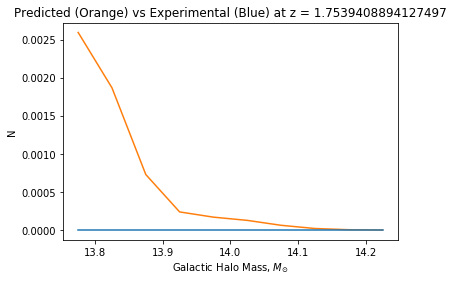

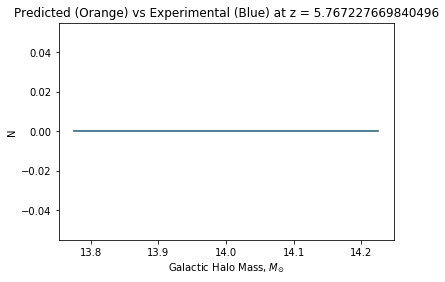

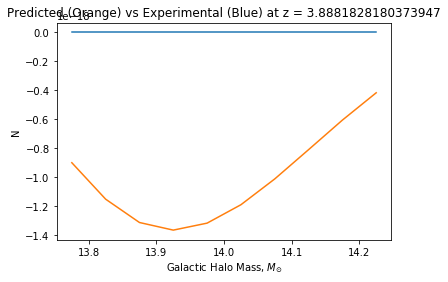

In [5]:
test_redshift(M_low=13.75, M_high=14.25, n_chunks=50, iterations=3)

In [5]:
def get_HMF_piecewise(p, **kwargs):

    ln_out_HMF = np.zeros(4001)
    res = []

    chunk_size = 50

    reg_bins = kwargs['reg_bins']
    offset = kwargs['offset']

    N_bin = reg_bins+1
    edge_der = np.zeros(N_bin+1)
    Mpiv = kwargs['Mpiv']
    ln_M_Mpiv = np.log(M_arr_full/Mpiv)

    if len(p)!=reg_bins+3:
        print("Wrong number of params")
        return -np.inf

    # ln_HMF = a + b*np.log(M_arr_full) + c*np.log(M_arr_full)^2
    # dln_HMF/dlnM = b + 2*c*np.log(M_arr_full)
    # d^2ln_HMF/dlnM^2 = 2*c

    # Pivot bin: 4th bin
    a, b, c = p[0], p[1], p[5]
    idx_lo, idx_hi = 3*chunk_size+offset, 4*chunk_size+offset
    ln_out_HMF[idx_lo:idx_hi] = a + b * ln_M_Mpiv[idx_lo:idx_hi] + c * ln_M_Mpiv[idx_lo:idx_hi]**2
    edge_der[3] = b + 2*c*ln_M_Mpiv[idx_lo]
    edge_der[4] = b + 2*c*ln_M_Mpiv[idx_hi]
    res.append((4, a, b, c, M_arr_full[idx_lo], M_arr_full[idx_hi]))

    # Go "left"
    for i in range(0,3)[::-1]:
        idx_lo = i*chunk_size+offset
        idx_hi = (i+1)*chunk_size+offset
        c = p[i+2]
        b = edge_der[i+1] - 2*c*ln_M_Mpiv[idx_hi+1]
        a = ln_out_HMF[idx_hi+1] - b*ln_M_Mpiv[idx_hi+1] - c*ln_M_Mpiv[idx_hi+1]**2
        edge_der[i] = b + 2*c*ln_M_Mpiv[idx_lo]
        ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi] + c*ln_M_Mpiv[idx_lo:idx_hi]**2

        res.append((i+1, a, b, c, M_arr_full[idx_lo], M_arr_full[idx_hi]))
    
    res.reverse()

    # Extend first bin (no curvature c=0)
    idx_lo = 0
    idx_hi = offset
    b = edge_der[0]
    a = ln_out_HMF[idx_hi+1] - b*ln_M_Mpiv[idx_hi+1]
    ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi]

    if offset != 0:
        res.insert(0, (0, a, b, M_arr_full[idx_lo], M_arr_full[idx_hi]))

    # Go "right"
    for i in range(4, N_bin-1):
        idx_lo = i*chunk_size+offset
        idx_hi = (i+1)*chunk_size+offset
        c = p[i+2]
        b = edge_der[i] - 2*c*ln_M_Mpiv[idx_lo]
        a = ln_out_HMF[idx_lo-1] - b*ln_M_Mpiv[idx_lo-1] - c*ln_M_Mpiv[idx_lo-1]**2
        edge_der[i+1] = b + 2*c*ln_M_Mpiv[idx_hi]
        ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi] + c*ln_M_Mpiv[idx_lo:idx_hi]**2
        
        res.append((i+1, a, b, c, M_arr_full[idx_lo], M_arr_full[idx_hi]))

    # Extend last bin with same curvature
    idx_lo = (N_bin-1)*chunk_size+offset
    idx_hi = len(ln_out_HMF)-1
    c = p[-1]
    b = edge_der[-2] - 2*c*ln_M_Mpiv[idx_lo]
    a = ln_out_HMF[idx_lo-1] - b*ln_M_Mpiv[idx_lo-1] - c*ln_M_Mpiv[idx_lo-1]**2
    edge_der[-1] = b + 2*c*ln_M_Mpiv[idx_hi]
    ln_out_HMF[idx_lo:idx_hi+1] = a + b*ln_M_Mpiv[idx_lo:idx_hi+1] + c*ln_M_Mpiv[idx_lo:idx_hi+1]**2

    if idx_lo < idx_hi:
        res.append((N_bin, a, b, c, M_arr_full[idx_lo], M_arr_full[idx_hi]))

    return (ln_out_HMF, res)

In [6]:
def f_polynomial(M, a, b, c):
    return a + b * np.log(M/Mpiv) + c * np.log(M/Mpiv)**2

def f_integrand(M, a, b, c):
    return 1e9 * (1/M) * np.e**(f_polynomial(M, a, b, c))

In [7]:
def f1_integrand(M, a, b, c):
    return np.exp(f_polynomial(M, a, b, c))

In [8]:
def integrate_dn_dlnM(param_list, zeroth_bin=False):
    '''Assumes param_list[0] doesn't have a c-parameter.'''
    res = np.ones((len(param_list), 1))


    for i in range(res.size):
        # 0th bin integration
        if zeroth_bin and i == 0:
            a, b, M_min, M_max = param_list[i][1:]
            res[i] = integrate.quad(f_integrand, M_min, M_max, args=(a, b, 0))[0]
        # i-th bin integration
        else:
            a, b, c, M_min, M_max = param_list[i][1:]
            res[i] = integrate.quad(f_integrand, M_min, M_max, args=(a, b, c))[0]
    
    return res

In [9]:
def likelihood_sim(N_sim, N_model, C, idx):
    assert N_sim.shape == N_model.shape
    assert C.shape[0] == C.shape[1]
    # assert len(idx) == N_sim.size - C[:, 0].size
    D = N_sim - N_model
#    print(" Product: ", D.T @ np.linalg.inv(C) @ D)
    for i in idx[::-1]:
        D = np.delete(D, i, axis=0)
    size = C.shape[0]
    D = D[:size]
    # print(D)
    # print(D.shape, C.shape)
    return (1/2) * D.T @ np.linalg.inv(C) @ D

def likelihood_var(lambd, c_arr):
    c_sum = 0
    for i in range(c_arr.size-1):
        c_sum += (c_arr[i] - c_arr[i+1])**2
    c_sum /= (2 * lambd**2)

    # print("lambd: ", lambd)
    # print("c_arr: ", c_arr[:10])

    return (c_arr.size - 1) * np.log(lambd) + c_sum

def likelihood_total(params, overwrite=True):
    '''[lambd, a4, b4, c1, c2, c3,..., cN]'''
    lambd = params[0]
    p = params[1:]
    _, hmf_piecewise_params = get_HMF_piecewise(p, reg_bins=len(p)-3, Mpiv=Mpiv, offset=0)
    N_model = integrate_dn_dlnM(hmf_piecewise_params, zeroth_bin=False)
    # print(N_model)
    print("var: ", likelihood_var(lambd, params[3:]))
    print("sim: ", likelihood_sim(Y, N_model, C2, idx))
    # print(likelihood_sim(Y, N_model, C2) + likelihood_var(lambd, params[3:]))
    if overwrite:
        # global params_trial
        # params_trial = params
        np.save("current_optimizer", params)
    return likelihood_sim(Y, N_model, C2, idx) + likelihood_var(lambd, params[3:])

In [10]:
def dn_dlnM(param_list, zeroth_bin=False):
    '''Assumes param_list[0] doesn't have a c-parameter.'''
    res = np.ones((len(param_list), 1))


    for i in range(res.size):
        # 0th bin integration
        if zeroth_bin and (i == 0):
            a, b, M_min, M_max = param_list[i][1:]
            # Assume M is the average of M_min and M_max (on log10 scale)
            res[i] = f1_integrand(np.sqrt(M_min * M_max), a, b, 0)
        # i-th bin integration
        else:
            a, b, c, M_min, M_max = param_list[i][1:]
            # Assume M is the average of M_min and M_max (on log10 scale)
            res[i] = f1_integrand(np.sqrt(M_min * M_max), a, b, c)
    
    return res

def likelihood_total1(params, overwrite=True):
    '''[lambd, a4, b4, c1, c2, c3,..., cN]'''
    lambd = params[0]
    p = params[1:]
    _, hmf_piecewise_params = get_HMF_piecewise(p, reg_bins=len(p)-3, Mpiv=Mpiv, offset=0)
    N_model = dn_dlnM(hmf_piecewise_params, zeroth_bin=False)
    # print(N_model)
    print("var:  ", likelihood_var(lambd, params[3:]))
    print("sim:  ", likelihood_sim(Y/(np.log(10) * 10**9), N_model, C2, idx))
    # print("params:  ", params[0], "; ", params[1:5], params[-3:])
    # print(likelihood_sim(Y, N_model, C) + likelihood_var(lambd, params[3:]))
    if overwrite:
        # global params_trial
        # params_trial = params
        np.save("current_optimizer", params)
    return likelihood_sim(Y/(np.log(10) * 10**9), N_model, C2, idx) + likelihood_var(lambd, params[3:])

In [14]:
filename = '/Users/rizo/Documents/ASTRO 4940/Halo_Emu_Cov_Mat/covmat_M200b_mnu0_00000_om0_30000_As2_1000.pkl'

pic_in = open(filename, "rb")
cov_matrices = pickle.load(pic_in, encoding="latin1")

C = cov_matrices[47]

idx = np.argwhere(np.all(C == 0, axis=0) | np.all(C == 0, axis=1))
for i in idx[::-1]:
    C = np.delete(C, i, axis=0)
    C = np.delete(C, i, axis=1)
print(C.shape)
C

(67, 67)


array([[ 4.71621007e+03,  4.09190451e+03,  3.17553001e+03, ...,
         1.61284722e+00,  2.12078373e+00, -6.20039683e-03],
       [ 4.09190451e+03,  5.09261483e+03,  3.04931176e+03, ...,
         1.02157738e+00,  1.35491071e+00,  2.75545635e-01],
       [ 3.17553001e+03,  3.04931176e+03,  2.98712674e+03, ...,
         1.52405754e+00,  1.41294643e+00, -5.55307540e-01],
       ...,
       [ 1.61284722e+00,  1.02157738e+00,  1.52405754e+00, ...,
         1.56250000e-02, -2.48015873e-04, -2.48015873e-04],
       [ 2.12078373e+00,  1.35491071e+00,  1.41294643e+00, ...,
        -2.48015873e-04,  1.56250000e-02, -2.48015873e-04],
       [-6.20039683e-03,  2.75545635e-01, -5.55307540e-01, ...,
        -2.48015873e-04, -2.48015873e-04,  1.56250000e-02]])

In [15]:
# https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

C1 = nearestPD(C)
C2 = C[:63, :63]

In [16]:
def plot_params(params):
    print(likelihood_total(params, overwrite=False))
    _, res = get_HMF_piecewise(params[1:], reg_bins=79, Mpiv=1e14, offset=0)
    N_model = integrate_dn_dlnM(res, False)
    plt.loglog(np.logspace(12.025, 15.975, 80), N_model)
    plt.loglog(np.power(10, X[:, 4]), Y)
    plt.show()

In [17]:
Mpiv = 1e14

n = 77600

indices = np.where((b.X[:, 3] == 0) & (b.X[:, 0] == b.X[n, 0]) & (b.X[:, 1] == b.X[n, 1]) & (b.X[:, 2] == b.X[n, 2]))
X = b.X[indices]
Y = b.Y[indices]

M_arr_full = np.logspace(12,16,4001)

In [37]:
arr = np.tile(np.linspace(-0.1,  -0.12, 10), 8)
# arr = np.tile(np.linspace(-0.3,  -0.5, 10), 8)
params = np.concatenate((np.ones((3, 1)), np.reshape(arr, (-1, 1))), axis=0)
params[0] = 1.01
params[1] = -13
params[2] = -1.5
# params[3] = -0.1
# params[4:10] = -0.1
# params[61:] = 0

print(likelihood_total(params, overwrite=False))
_, res = get_HMF_piecewise(params[1:], reg_bins=79, Mpiv=1e14, offset=0)
N_model = integrate_dn_dlnM(res, False)
plt.loglog(np.logspace(12.025, 15.975, 80), N_model)
plt.loglog(np.power(10, X[:, 4]), Y)
plt.show()

var:[0.78762283]


AssertionError: 

var:381.1212864143303
sim:[[20138.46493361]]
[[20519.58622002]]


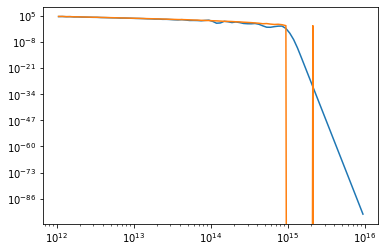

In [17]:
q = np.load("current_optimizer.npy")
plot_params(q)

In [18]:
x_max = []
x_max.append(100.)
x_max.append(20.)
x_max.append(20.)
for i in range(80):
    x_max.append(0.)

x_min = []
x_min.append(1.)
x_min.append(-20.)
x_min.append(-20.)
for i in range(80):
    x_min.append(-20.)

class MyBounds(object):
    def __init__(self, x_max=x_max, x_min=x_min):
        self.x_max = np.array(x_max)
        self.x_min = np.array(x_min)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        t_max = bool(np.all(x <= self.x_max))
        t_min = bool(np.all(x >= self.x_min))
        return t_max and t_min

bounds = MyBounds()

In [46]:
optimize_res = optimize.basinhopping(likelihood_total, q, accept_test=bounds)

453590.28912228]]
var:1540.9681453968067
sim:[[453590.28693388]]
var:1540.9681453589812
sim:[[453585.1524694]]
var:1540.9681453406165
sim:[[453590.32523593]]
var:1540.9681454050176
sim:[[453590.3256299]]
var:1540.9681453197322
sim:[[453590.32665422]]
var:1540.9681454147149
sim:[[453590.32717024]]
var:1540.9681452944371
sim:[[453590.32629049]]
var:1540.9681454426318
sim:[[453590.32279076]]
var:1540.9681453115088
sim:[[453590.31807851]]
var:1540.9681453794499
sim:[[453590.31378051]]
var:1540.968145362288
sim:[[453590.31109943]]
var:1540.9681453724193
sim:[[453590.30817887]]
var:1540.9681453560395
sim:[[453590.3056361]]
var:1540.9681453643232
sim:[[453590.30394663]]
var:1540.9681453704388
sim:[[453590.30368006]]
var:1540.9681453555527
sim:[[453590.30348689]]
var:1540.9681453670732
sim:[[453590.30329375]]
var:1540.9681453741607
sim:[[453590.30388858]]
var:1540.9681453501341
sim:[[453590.30418184]]
var:1540.9681453691483
sim:[[453590.30360767]]
var:1540.9681453706003
sim:[[453590.30252236]]

In [29]:
params.flatten()

array([  1.01      , -13.        ,  -1.5       ,  -0.1       ,
        -0.10222222,  -0.10444444,  -0.10666667,  -0.10888889,
        -0.11111111,  -0.11333333,  -0.11555556,  -0.11777778,
        -0.12      ,  -0.1       ,  -0.10222222,  -0.10444444,
        -0.10666667,  -0.10888889,  -0.11111111,  -0.11333333,
        -0.11555556,  -0.11777778,  -0.12      ,  -0.1       ,
        -0.10222222,  -0.10444444,  -0.10666667,  -0.10888889,
        -0.11111111,  -0.11333333,  -0.11555556,  -0.11777778,
        -0.12      ,  -0.1       ,  -0.10222222,  -0.10444444,
        -0.10666667,  -0.10888889,  -0.11111111,  -0.11333333,
        -0.11555556,  -0.11777778,  -0.12      ,  -0.1       ,
        -0.10222222,  -0.10444444,  -0.10666667,  -0.10888889,
        -0.11111111,  -0.11333333,  -0.11555556,  -0.11777778,
        -0.12      ,  -0.1       ,  -0.10222222,  -0.10444444,
        -0.10666667,  -0.10888889,  -0.11111111,  -0.11333333,
        -0.11555556,  -0.11777778,  -0.12      ,  -0.1 

In [30]:
bnd_lower = np.ones((83,))
bnd_higher = np.ones((83,))

bnd_lower[0] = -np.inf
bnd_lower[1] = -np.inf
bnd_lower[2] = -np.inf
for i in range(3, bnd_lower.size):
    bnd_lower[i] = - np.inf

bnd_higher[0] = np.inf
bnd_higher[1] = np.inf
bnd_higher[2] = np.inf
for i in range(3, bnd_higher.size):
    bnd_higher[i] = 0.

bnd = optimize.Bounds(bnd_lower, bnd_higher, True)

bnd_higher

array([inf, inf, inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [25]:
# Constraints:
# lambd >= 1
def constraint1(params):
    return params[0] - 1
    # lambd = params[0].item()
    # if lambd >= 1 : return 0 
    # else : return lambd - 1
# c_n <= 0
def constraint2(params):
    sum = 0
    for el in params[3:]:
        if el > 0 : sum += el 
    return sum 

con1 = {'type': 'eq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = [con1, con2]

# Bounds: 
# c_n <= 0
# lambd >= 1
b_lambd = (None, None)
b_a = (None, None)
b_b = (None, None)
b_c = (-np.inf, 0.)
bnds = [b_lambd, b_a, b_b]
for i in range(80):
    bnds.append(b_c)

In [37]:
params_guess = np.load("current_optimizer.npy")

In [38]:
params_guess

array([  5.        , -13.        ,  -1.5       ,  -0.1       ,
        -0.10222222,  -0.10444444,  -0.10666667,  -0.10888889,
        -0.11111111,  -0.11333333,  -0.11555556,  -0.11777778,
        -0.12      ,  -0.1       ,  -0.10222222,  -0.10444444,
        -0.10666667,  -0.10888889,  -0.11111111,  -0.11333333,
        -0.11555556,  -0.11777778,  -0.12      ,  -0.1       ,
        -0.10222222,  -0.10444444,  -0.10666667,  -0.10888889,
        -0.11111111,  -0.11333333,  -0.11555556,  -0.11777778,
        -0.12      ,  -0.1       ,  -0.10222222,  -0.10444444,
        -0.10666667,  -0.10888889,  -0.11111111,  -0.11333333,
        -0.11555556,  -0.11777778,  -0.12      ,  -0.1       ,
        -0.10222222,  -0.10444444,  -0.10666667,  -0.10888889,
        -0.11111111,  -0.11333333,  -0.11555556,  -0.11777778,
        -0.12      ,  -0.1       ,  -0.10222222,  -0.10444444,
        -0.10666667,  -0.10888889,  -0.11111111,  -0.11333333,
        -0.11555556,  -0.11777778,  -0.12      ,  -0.1 

var:1.8288007293512336
sim:[[22526330.22687554]]
[[2.21007599]]


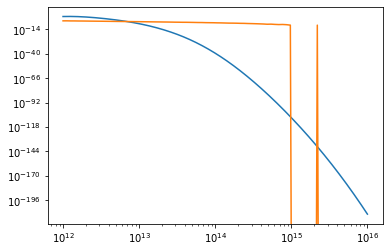

In [26]:
plot_params(params_guess)

In [20]:
optimize_res = optimize.minimize(likelihood_total1, qwe, method='SLSQP', bounds=bnds)

var:1.4776393126634255e-05
sim:[[0.00183275]]
var:1.4776393126634255e-05
sim:[[0.00183275]]
var:1.5953584411896356e-05
sim:[[0.00183275]]
var:1.4776393126634255e-05
sim:[[0.00183275]]
var:1.4776393126634255e-05
sim:[[0.00183275]]
var:1.4776392275011755e-05
sim:[[0.00183275]]
var:1.4776391601184035e-05
sim:[[0.00183275]]
var:1.4776395010137056e-05
sim:[[0.00183275]]
var:1.4776389863167837e-05
sim:[[0.00183275]]
var:1.4776394044350777e-05
sim:[[0.00183275]]
var:1.4776391364374226e-05
sim:[[0.00183275]]
var:1.47763930741626e-05
sim:[[0.00183275]]
var:1.4776393157720574e-05
sim:[[0.00183275]]
var:1.4776392068843407e-05
sim:[[0.00183275]]
var:1.4776392710161413e-05
sim:[[0.00183275]]
var:1.4776392454450145e-05
sim:[[0.00183275]]
var:1.4776394177810762e-05
sim:[[0.00183275]]
var:1.477639287368344e-05
sim:[[0.00183275]]
var:1.4776392848170483e-05
sim:[[0.00183275]]
var:1.4776393420919942e-05
sim:[[0.00183275]]
var:1.4776393673459454e-05
sim:[[0.00183275]]
var:1.4776393578977618e-05
sim:[[0.00

In [29]:
plot_params(optimize_res.x)

array([1.00000000e+12, 1.00230524e+12, 1.00461579e+12, ...,
       9.95405417e+15, 9.97700064e+15, 1.00000000e+16])

In [18]:
params_guess1 = np.array([1.        , -21.58343491,   6.41286863,  -2.54004954,
        -2.53986421,  -2.54028199,  -2.53967209,  -2.53941429,
        -2.5392639 ,  -2.53931083,  -2.53890173,  -2.53813922,
        -2.53804607,  -2.53768057,  -2.5371372 ,  -2.53679834,
        -2.53623422,  -2.53571431,  -2.53557072,  -2.53525168,
        -2.53472978,  -2.53432493,  -2.53414511,  -2.53402245,
        -2.53368857,  -2.53355576,  -2.53309701,  -2.53299404,
        -2.53271517,  -2.53236063,  -2.53227118,  -2.5319815 ,
        -2.53210004,  -2.53229512,  -2.53241336,  -2.53290054,
        -2.53314017,  -2.53341691,  -2.53361995,  -2.53408435,
        -2.53424414,  -2.534555  ,  -2.53512352,  -2.53559827,
        -2.53656616,  -2.53750404,  -2.53809944,  -2.53926834,
        -2.54030167,  -2.5414912 ,  -2.54264773,  -2.54383645,
        -2.54502451,  -2.54633876,  -2.54753023,  -2.5484435 ,
        -2.54955296,  -2.55044507,  -2.55142693,  -2.55268562,
        -2.55353629,  -2.55493871,  -2.55592361,  -2.5568654 ,
        -2.55811086,  -2.55900325,  -2.55962918,  -2.56022472,
        -2.56075145,  -2.56106703,  -2.56137905,  -2.56136071,
        -2.56088496,  -2.56121605,  -2.56138257,  -2.56123234,
        -2.56122964,  -2.56181075,  -2.56247403,  -2.5627841 ,
        -2.56311132,  -2.56327957,  -2.56386257])

var:1.688405760705037e-05
sim:[[0.00183241]]
[[1.68841802e-05]]


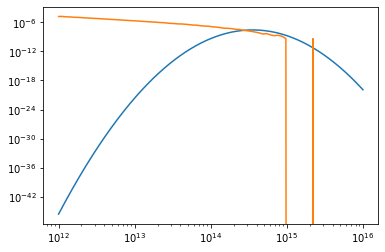

In [19]:
plot_params(params_guess1)

In [25]:
plot_params(optimize_res.x)

NameError: name 'optimize_res' is not defined

In [8]:
qwe = np.load("current_optimizer.npy")

In [9]:
qwe 

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [120]:
params

array([[  5.        ],
       [-13.        ],
       [ -1.5       ],
       [ -0.1       ],
       [ -0.10222222],
       [ -0.10444444],
       [ -0.10666667],
       [ -0.10888889],
       [ -0.11111111],
       [ -0.11333333],
       [ -0.11555556],
       [ -0.11777778],
       [ -0.12      ],
       [ -0.1       ],
       [ -0.10222222],
       [ -0.10444444],
       [ -0.10666667],
       [ -0.10888889],
       [ -0.11111111],
       [ -0.11333333],
       [ -0.11555556],
       [ -0.11777778],
       [ -0.12      ],
       [ -0.1       ],
       [ -0.10222222],
       [ -0.10444444],
       [ -0.10666667],
       [ -0.10888889],
       [ -0.11111111],
       [ -0.11333333],
       [ -0.11555556],
       [ -0.11777778],
       [ -0.12      ],
       [ -0.1       ],
       [ -0.10222222],
       [ -0.10444444],
       [ -0.10666667],
       [ -0.10888889],
       [ -0.11111111],
       [ -0.11333333],
       [ -0.11555556],
       [ -0.11777778],
       [ -0.12      ],
       [ -0

In [11]:
filelist = glob.glob("/Users/rizo/Documents/ASTRO 4940/Halo_Emu/dndm_M200c_mnu0.00000_om0.30000_As2.100020bins.pkl")
points = []
for filename in filelist:
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    points.append(HaloEmulator.reshape_data(data))
point_list = np.concatenate(points, axis=0)

In [19]:
point_list.shape

(960, 6)

In [39]:
n = 46
redshift = point_list[n*20, 3]
print("Redshift: ", redshift)

redshift_ind = np.where(point_list[:, 3] == redshift)
X_20 = point_list[redshift_ind][:, :5]
Y_20 = np.reshape(point_list[redshift_ind][:, 5], (-1, 1))

Redshift:0.042437636168416226


In [40]:
filename = '/Users/rizo/Documents/ASTRO 4940/Halo_Emu_Cov_Mat/covmat_M200c_mnu0.00000_om0.30000_As2.100020bins.pkl'

pic_in = open(filename, "rb")
cov_matrices = pickle.load(pic_in, encoding="latin1")

C_20 = cov_matrices[n]

idx = np.argwhere(np.all(C_20 == 0, axis=0) | np.all(C_20 == 0, axis=1))
for i in idx[::-1]:
    C_20 = np.delete(C_20, i, axis=0)
    C_20 = np.delete(C_20, i, axis=1)
print(C_20.shape)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

is_pos_def(C_20)

(19, 19)


True

In [41]:
X_20[:, 4]

array([13.0625, 13.1875, 13.3125, 13.4375, 13.5625, 13.6875, 13.8125,
       13.9375, 14.0625, 14.1875, 14.3125, 14.4375, 14.5625, 14.6875,
       14.8125, 14.9375, 15.0625, 15.1875, 15.3125, 15.4375])

In [42]:
def likelihood_total2(params, overwrite=True):
    '''[lambd, a4, b4, c1, c2, c3,..., cN]'''
    lambd = params[0]
    p = params[1:]
    _, hmf_piecewise_params = get_HMF_piecewise_20(p, reg_bins=len(p)-3, Mpiv=Mpiv, offset=0)
    N_model = integrate_dn_dlnM(hmf_piecewise_params, zeroth_bin=False)
    # print(N_model)
    print("var: ", likelihood_var(lambd, params[3:]))
    print("sim: ", likelihood_sim(Y_20, N_model, C_20, idx))
    # print(likelihood_sim(Y, N_model, C2) + likelihood_var(lambd, params[3:]))
    if overwrite:
        # global params_trial
        # params_trial = params
        np.save("current_optimizer", params)
    return likelihood_sim(Y_20, N_model, C_20, idx) + likelihood_var(lambd, params[3:])

In [55]:
def fasd(x):
    global fasda
    fasda = x

fasd(3)
fasda

3

In [67]:
qwe = np.load("20bins_optimized.npy")
qwe.shape

(23,)

In [43]:
def get_HMF_piecewise_20(p, **kwargs):

    ln_out_HMF = np.zeros(1001)
    res = []

    chunk_size = 50

    reg_bins = kwargs['reg_bins']
    offset = kwargs['offset']

    N_bin = reg_bins+1
    edge_der = np.zeros(N_bin+1)
    Mpiv = kwargs['Mpiv']
    ln_M_Mpiv = np.log(M_arr_full_20/Mpiv)

    if len(p)!=reg_bins+3:
        print("Wrong number of params")
        return -np.inf

    # ln_HMF = a + b*np.log(M_arr_full) + c*np.log(M_arr_full)^2
    # dln_HMF/dlnM = b + 2*c*np.log(M_arr_full)
    # d^2ln_HMF/dlnM^2 = 2*c

    # Pivot bin: 4th bin
    a, b, c = p[0], p[1], p[5]
    idx_lo, idx_hi = 3*chunk_size+offset, 4*chunk_size+offset
    ln_out_HMF[idx_lo:idx_hi] = a + b * ln_M_Mpiv[idx_lo:idx_hi] + c * ln_M_Mpiv[idx_lo:idx_hi]**2
    edge_der[3] = b + 2*c*ln_M_Mpiv[idx_lo]
    edge_der[4] = b + 2*c*ln_M_Mpiv[idx_hi]
    res.append((4, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    # Go "left"
    for i in range(0,3)[::-1]:
        idx_lo = i*chunk_size+offset
        idx_hi = (i+1)*chunk_size+offset
        c = p[i+2]
        b = edge_der[i+1] - 2*c*ln_M_Mpiv[idx_hi+1]
        a = ln_out_HMF[idx_hi+1] - b*ln_M_Mpiv[idx_hi+1] - c*ln_M_Mpiv[idx_hi+1]**2
        edge_der[i] = b + 2*c*ln_M_Mpiv[idx_lo]
        ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi] + c*ln_M_Mpiv[idx_lo:idx_hi]**2

        res.append((i+1, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))
    
    res.reverse()

    # Extend first bin (no curvature c=0)
    idx_lo = 0
    idx_hi = offset
    b = edge_der[0]
    a = ln_out_HMF[idx_hi+1] - b*ln_M_Mpiv[idx_hi+1]
    ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi]

    if offset != 0:
        res.insert(0, (0, a, b, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    # Go "right"
    for i in range(4, N_bin-1):
        idx_lo = i*chunk_size+offset
        idx_hi = (i+1)*chunk_size+offset
        c = p[i+2]
        b = edge_der[i] - 2*c*ln_M_Mpiv[idx_lo]
        a = ln_out_HMF[idx_lo-1] - b*ln_M_Mpiv[idx_lo-1] - c*ln_M_Mpiv[idx_lo-1]**2
        edge_der[i+1] = b + 2*c*ln_M_Mpiv[idx_hi]
        ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi] + c*ln_M_Mpiv[idx_lo:idx_hi]**2
        
        res.append((i+1, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    # Extend last bin with same curvature
    idx_lo = (N_bin-1)*chunk_size+offset
    idx_hi = len(ln_out_HMF)-1
    c = p[-1]
    b = edge_der[-2] - 2*c*ln_M_Mpiv[idx_lo]
    a = ln_out_HMF[idx_lo-1] - b*ln_M_Mpiv[idx_lo-1] - c*ln_M_Mpiv[idx_lo-1]**2
    edge_der[-1] = b + 2*c*ln_M_Mpiv[idx_hi]
    ln_out_HMF[idx_lo:idx_hi+1] = a + b*ln_M_Mpiv[idx_lo:idx_hi+1] + c*ln_M_Mpiv[idx_lo:idx_hi+1]**2

    if idx_lo < idx_hi:
        res.append((N_bin, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    return (ln_out_HMF, res)

In [74]:
for i in range(3,6)[::-1]:
    print(i)

5
4
3


var:[0.19600005]
sim:[[227360.55739831]]
[[227360.75339836]]


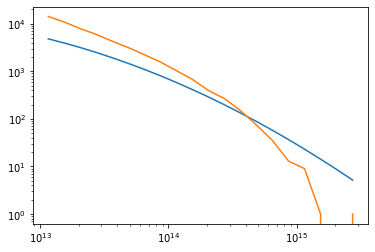

In [44]:
Mpiv = 1e14

M_arr_full_20 = np.logspace(13, 15.5,1001)

arr = np.tile(np.linspace(-0.08,  -0.13, 4), 5)
# arr = np.tile(np.linspace(-0.3,  -0.2, 10), 8)
params = np.concatenate((np.ones((3, 1)), np.reshape(arr, (-1, 1))), axis=0)
params[0] = 1.01
params[1] = -13
params[2] = -1.2
# params[3] = -0.1
# params[4:10] = -0.1
# params[61:] = 0

print(likelihood_total2(params, overwrite=False))
_, res = get_HMF_piecewise_20(params[1:], reg_bins=19, Mpiv=1e14, offset=0)
N_model = integrate_dn_dlnM(res, False)
plt.loglog(np.logspace(13.0625, 15.4375, 20), N_model)
plt.loglog(np.power(10, X_20[:, 4]), Y_20)
plt.show()

def plot_params_20(params):
    print(likelihood_total2(params, overwrite=False))
    _, res = get_HMF_piecewise_20(params[1:], reg_bins=19, Mpiv=1e14, offset=0)
    N_model = integrate_dn_dlnM(res, False)
    plt.loglog(np.logspace(13.0625, 15.4375, 20), N_model)
    plt.loglog(np.power(10, X_20[:, 4]), Y_20)
    plt.show()

In [98]:
import scipy
_, s, _ = scipy.linalg.svd(X)
np.diagflat(s)

array([[1.13261278e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 7.69218040e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.00993796e-16, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.01630572e-19,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [128]:
def load_cov_matrices(path):
    pic_in = open(path, "rb")
    cov_matrices = pickle.load(pic_in, encoding="latin1")

    return cov_matrices

In [133]:
casd = load_cov_matrices("/Users/rizo/Documents/ASTRO 4940/Halo_Emu_Cov_Mat/covmat_M200c_mnu0.06271_om0.38154_As2.200420bins.pkl")
len(casd.shape)

3

In [160]:
np.load("../hmf_params/current_optimizer_0.00000_0.30000_2.1000.npy")

array([ 9.9967e-01, -1.2311e+01, -1.2817e+00, -2.8755e-01,  5.0164e-04,
        5.5043e-04, -8.9134e-02, -5.1911e-02,  5.6714e-04, -3.2195e-01,
       -2.9147e-01,  2.1155e-03, -2.6903e-01,  4.3406e-04, -1.7871e-01,
       -1.4636e+00,  4.0131e-04, -4.0168e-01, -9.3935e-01, -3.8899e+00,
       -4.5067e+00, -4.6931e+00, -4.7391e+00])

In [195]:
asd= np.array([[1,2,3],
[4,5,6]])
asd[:, 0] = np.array([3,2])
asd

array([[3, 2, 3],
       [2, 5, 6]])

In [187]:
params = np.ones((27, 23))
i = 0
for fname in filelist:
    params[i] = np.load(fname)
    i += 1

ind_h, ind_v = np.where(params[:, 1:] > 0)
params[ind_h, ind_v+1] = 0
params

array([[ 9.9967e-01, -1.2311e+01, -1.2817e+00, -2.8755e-01,  0.0000e+00,
         0.0000e+00, -8.9134e-02, -5.1911e-02,  0.0000e+00, -3.2195e-01,
        -2.9147e-01,  0.0000e+00, -2.6903e-01,  0.0000e+00, -1.7871e-01,
        -1.4636e+00,  0.0000e+00, -4.0168e-01, -9.3935e-01, -3.8899e+00,
        -4.5067e+00, -4.6931e+00, -4.7391e+00],
       [ 9.9917e-01, -1.1537e+01, -9.4851e-01,  0.0000e+00,  0.0000e+00,
        -1.2456e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -5.4536e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.9525e-01,
         0.0000e+00,  0.0000e+00, -1.5974e+00, -1.1130e+00,  0.0000e+00,
        -1.9723e+00, -1.8479e+00, -1.5881e+00],
       [ 9.9960e-01, -1.2771e+01, -1.4947e+00,  0.0000e+00,  0.0000e+00,
        -4.0895e-02, -1.3397e-01,  0.0000e+00, -4.1305e-01,  0.0000e+00,
         0.0000e+00, -4.7342e-01,  0.0000e+00, -3.8030e-01, -1.4260e+00,
        -8.4610e-02, -6.8219e-01, -1.3319e+00, -4.7866e-01, -8.1204e-01,
        -1.1984e-01, -1.5048

In [119]:
qwe = np.ones((1, 3))
q, w, e = qwe[0, 0]/27, qwe[0, 1], qwe[0, 2]
np.set_printoptions(precision=4)
"{:.5f}".format(q)

'0.03704'

In [45]:
x_max = []
x_max.append(100.)
x_max.append(20.)
x_max.append(20.)
for i in range(20):
    x_max.append(0.)

x_min = []
x_min.append(1.)
x_min.append(-20.)
x_min.append(-20.)
for i in range(20):
    x_min.append(-20.)

class MyBounds(object):
    def __init__(self, x_max=x_max, x_min=x_min):
        self.x_max = np.array(x_max)
        self.x_min = np.array(x_min)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        t_max = bool(np.all(x <= self.x_max))
        t_min = bool(np.all(x >= self.x_min))
        return t_max and t_min

bounds = MyBounds()

In [ ]:
optimize_res = optimize.basinhopping(likelihood_total2, q, accept_test=bounds)

In [46]:
q = np.array([9.99598990e-01, -1.23361579e+01, -1.28837760e+00, -8.68204395e-01,
        5.33826117e-04,  6.37114429e-04, -8.49860698e-02, -3.50029683e-02,
        9.46921481e-05, -1.48822673e-01, -5.96261189e-01, -5.66495853e-02,
        4.57215090e-04,  5.09067664e-04, -4.70274548e-01, -1.06995530e+00,
       -4.51663130e-01, -1.50185126e+00,  2.44959923e-04, -1.80043002e-01,
        3.33967552e-04,  3.24636765e-04,  2.42497451e-04])

var:2.829831652609826
sim:[[229.14801756]]
[[231.97784921]]


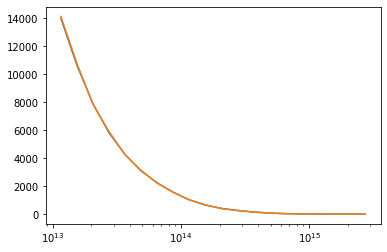

In [47]:
# q= np.load("current_optimizer.npy")
print(likelihood_total2(q, overwrite=False))
_, res = get_HMF_piecewise_20(q[1:], reg_bins=19, Mpiv=1e14, offset=0)
N_model = integrate_dn_dlnM(res, False)
plt.plot(np.logspace(13.0625, 15.4375, 20), N_model)
plt.plot(np.power(10, X_20[:, 4]), Y_20)
plt.xscale("log")
plt.show()

In [51]:
q[np.where((q[1:] > 0))[0] + 1] = 0
q

array([  0.99965253, -12.31234685,  -1.2833186 ,  -0.28866772,
         0.        ,   0.        ,  -0.08969696,  -0.05068166,
         0.        ,  -0.32531982,  -0.2864317 ,   0.        ,
        -0.27115605,   0.        ,  -0.17418796,  -1.46884992,
         0.        ,  -0.3961493 ,  -0.92393965,  -3.91587869,
        -4.53055169,  -4.75719898,  -4.7763457 ])

var:2.829831652609826
sim:[[229.14801756]]
[[231.97784921]]


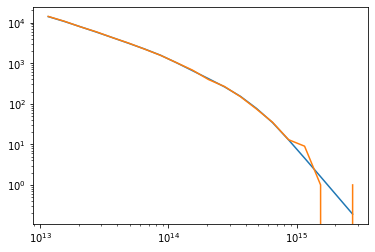

In [48]:
plot_params_20(q)

var:58.67229575940692
sim:[[32.31951294]]
[[90.9918087]]


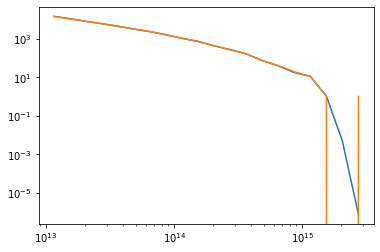

In [81]:
q1 = np.array([1.40100713e+01, -1.13290919e+01,  3.30838808e-01, -3.65556757e+01,
  9.33137061e+00, -2.60922594e+00,  5.73109852e-01, -3.71945849e-01,
  3.49674500e-01, -5.49853547e-01, -5.34620500e-01,  1.08230886e+00,
 -1.96393949e+00,  1.17409679e+00, -8.31442358e-03, -3.49802426e+00,
  3.55407629e+00, -4.35127276e+00,  8.31931037e+00, -1.94278830e+01,
 -2.15859271e+01, -2.14899908e+01, -2.17721080e+01])

plot_params_20(q1)

In [82]:
q

array([  6.59545738, -12.64861099,  -1.86363721,  -0.34186456,
        -0.30276506,   0.38454443,  -0.33004233,  -0.11995496,
         0.27978744,  -0.51151084,  -0.5686837 ,   1.07947394,
        -1.92445927,   1.16788643,  -0.07231666,  -3.38217551,
         3.364796  ,  -3.81030435,   6.92277513, -16.96179316,
       -19.804905  , -19.78496701, -19.78135714])

In [28]:
optimize_res = optimize.basinhopping(likelihood_total2, q, accept_test=bounds)

var:45.33827343447979


AssertionError: 

In [29]:
M_arr_full_20

array([1.00000000e+13, 1.00577306e+13, 1.01157945e+13, ...,
       3.12607937e+15, 3.14412642e+15, 3.16227766e+15])

In [154]:
from horuslp.core.Variables import Variable, BinaryVariable
from horuslp.core import Constraint, VariableManager, Problem, ObjectiveComponent
from horuslp.core.constants import MAXIMIZE, MINIMIZE

from horuslp.core import CombinedObjective

In [54]:
class KnapsackVariables(VariableManager):
    vars = [
        BinaryVariable('camera'),
        BinaryVariable('figurine'),
        BinaryVariable('cider'),
        BinaryVariable('horn')
    ]

class SizeConstraint(Constraint):

    def define(self, camera, figurine, cider, horn):
        return 2 * camera + 4 * figurine + 7 * cider + 10 * horn <= 15

class SizeConstraint2(Constraint):
    def define(self, camera, figurine, cider, horn):
        return 2 * camera + 4 * figurine + 7 * cider + 10 * horn <= 20

class MustHaveItemConstraint(Constraint):
    def define(self, camera):
        return camera >= 1

class ILoveCiderFigurineObjectiveComponent(ObjectiveComponent):
    def define(self, figurine, cider):
        return figurine + cider

class ValueObjective(ObjectiveComponent):
    def define(self, camera, figurine, cider, horn):
        return 5 * camera + 7 * figurine + 2 * cider + 10 * horn

class Combined(CombinedObjective):
    objectives = [
        (ILoveCiderFigurineObjectiveComponent, 2), # first argument is the objective, second argument is the weight
        (ValueObjective, 1)
    ]

In [55]:
class IncompatibleConstraint1(Constraint):
    def define(self, camera):
        return camera >= 1


class IncompatibleConstraint2(Constraint):
    def define(self, camera):
        return camera <= 0

In [56]:
class CombinedConstraints1(Constraint):
    dependent_constraints = [SizeConstraint2, IncompatibleConstraint1]


class CombinedConstraints2(Constraint):
    dependent_constraints = [SizeConstraint, IncompatibleConstraint2]

In [57]:
class KnapsackProblem(Problem):
    variables = KnapsackVariables
    objective = ValueObjective
    constraints = [CombinedConstraints1, CombinedConstraints2, MustHaveItemConstraint]
    sense = MAXIMIZE

In [58]:
prob = KnapsackProblem()
prob.solve()

'Infeasible'

In [61]:
prob.print_results(find_infeasible=True, deep_infeasibility_search=True)

KnapsackProblem: Infeasible
Finding incompatible constraints...
Incompatible Constraints:('IncompatibleConstraint1', 'IncompatibleConstraint2')


In [224]:
class LikelihoodVariables(VariableManager):
    vars = [
        Variable('lambd', 1., 100.),
        Variable('a4', -100., 100.),
        Variable('b4', -100., 100.),
        Variable('c1', -100., 0.),
        Variable('c2', -100., 0.),
        Variable('c3', -100., 0.),
        Variable('c4', -100., 0.),
        Variable('c5', -100., 0.),
        Variable('c6', -100., 0.),
        Variable('c7', -100., 0.),
        Variable('c8', -100., 0.),
        Variable('c9', -100., 0.),
        Variable('c10', -100., 0.),
        Variable('c11', -100., 0.),
        Variable('c12', -100., 0.),
        Variable('c13', -100., 0.),
        Variable('c14', -100., 0.),
        Variable('c15', -100., 0.),
        Variable('c16', -100., 0.),
        Variable('c17', -100., 0.),
        Variable('c18', -100., 0.),
        Variable('c19', -100., 0.),
        Variable('c20', -100., 0.)
    ]

class PositiveConstraint(Constraint):
    def define(self, lambd, a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20):
        return (c1 <= 0) and (c2 <= 0) and (c3 <= 0) and (c4 <= 0) and (c5 <= 0) and (c6 <= 0) and (c7 <= 0) and (c8 <= 0) and (c9 <= 0) and (c10 <= 0) and (c11 <= 0) and (c12 <= 0) and (c13 <= 0) and (c14 <= 0) and (c15 <= 0) and (c16 <= 0) and (c17 <= 0) and (c18 <= 0) and (c19 <= 0) and (c20 <= 0)

class LambdConstraint(Constraint):
    def define(self, lambd, a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20):
        return lambd >= 1

class LikelihoodObjective(ObjectiveComponent):
    def define(self, lambd, a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20):
        print(type(a4))
        _, hmf_piecewise_params = get_HMF_piecewise_20_optimization(a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20, reg_bins=19, Mpiv=Mpiv, offset=0)
        N_model = integrate_dn_dlnM(hmf_piecewise_params, zeroth_bin=False)
        print("var: ", likelihood_var(lambd, p[2:]))
        print("sim: ", likelihood_sim(Y_20, N_model, C_20, idx))
        return likelihood_sim(Y_20, N_model, C_20, idx) + likelihood_var(lambd, p[2:])

class LikelihoodObjective1(ObjectiveComponent):
    def define(self, lambd, a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20):
        return f(a4, b4, c1, c2)

def f(a4, b4, c1, c2):
    print(type(a4))
    a = np.zeros(3)
    p = [a4, b4, c1, c2]
    q1 = p[0] + p[1]
    q2 = p[2] - p[3]
    
    return 2**a4

In [225]:
class LikelihoodProblem(Problem):
    variables = LikelihoodVariables
    objective = LikelihoodObjective1
    constraints = []
    sense = MINIMIZE

In [226]:
prob = LikelihoodProblem()
prob.solve()

<class 'pulp.pulp.LpVariable'>


TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'LpVariable'

In [193]:
prob.print_results()

KeyError: None

In [218]:
def get_HMF_piecewise_20_optimization(a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20, **kwargs):
    p = [a4, b4, c1, c2, c3, c4, c5, c6, c7 ,c8, c9, c10, c11, c12, c13, c14, c15, c16, c17 ,c18, c19, c20]
    print(p)

    ln_out_HMF = np.zeros(1001)
    res = []

    chunk_size = 50

    reg_bins = kwargs['reg_bins']
    offset = kwargs['offset']

    N_bin = reg_bins+1
    edge_der = [0] * (N_bin+1)
    edge_HMF = [0] * (N_bin+1)
    Mpiv = kwargs['Mpiv']
    ln_M_Mpiv = np.log(M_arr_full_20/Mpiv)

    if len(p)!=reg_bins+3:
        print("Wrong number of params")
        return -np.inf

    # ln_HMF = a + b*np.log(M_arr_full) + c*np.log(M_arr_full)^2
    # dln_HMF/dlnM = b + 2*c*np.log(M_arr_full)
    # d^2ln_HMF/dlnM^2 = 2*c

    # Pivot bin: 4th bin
    a, b, c = p[0], p[1], p[5]
    idx_lo, idx_hi = 3*chunk_size+offset, 4*chunk_size+offset
    edge_HMF[3] = a + b * ln_M_Mpiv[idx_lo] + c * ln_M_Mpiv[idx_lo]**2
    edge_HMF[4] = a + b * ln_M_Mpiv[idx_hi] + c * ln_M_Mpiv[idx_hi]**2
    edge_der[3] = b + 2*c*ln_M_Mpiv[idx_lo]
    edge_der[4] = b + 2*c*ln_M_Mpiv[idx_hi]
    res.append((4, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    # Go "left"
    for i in range(0,3)[::-1]:
        idx_lo = i*chunk_size+offset
        idx_hi = (i+1)*chunk_size+offset
        c = p[i+2]
        b = edge_der[i+1] - 2*c*ln_M_Mpiv[idx_hi+1]
        a = edge_HMF[i+1] - b*ln_M_Mpiv[idx_hi+1] - c*ln_M_Mpiv[idx_hi+1]**2
        edge_der[i] = b + 2*c*ln_M_Mpiv[idx_lo]
        edge_HMF[i] = a + b*ln_M_Mpiv[idx_lo] + c*ln_M_Mpiv[idx_lo]**2

        res.append((i+1, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))
    
    res.reverse()

    # Extend first bin (no curvature c=0)
    # idx_lo = 0
    # idx_hi = offset
    # b = edge_der[0]
    # a = edge_HMF[0] - b*edge_HMF[0]
    # ln_out_HMF[idx_lo:idx_hi] = a + b*ln_M_Mpiv[idx_lo:idx_hi]

    if offset != 0:
        res.insert(0, (0, a, b, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    # Go "right"
    for i in range(4, N_bin-1):
        idx_lo = i*chunk_size+offset
        idx_hi = (i+1)*chunk_size+offset
        c = p[i+2]
        b = edge_der[i] - 2*c*ln_M_Mpiv[idx_lo]
        a = edge_HMF[i] - b*ln_M_Mpiv[idx_lo-1] - c*ln_M_Mpiv[idx_lo-1]**2
        edge_der[i] = b + 2*c*ln_M_Mpiv[idx_hi]
        edge_HMF[i] = a + b*ln_M_Mpiv[idx_lo] + c*ln_M_Mpiv[idx_lo]**2
        
        res.append((i+1, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    print(edge_HMF)

    # Extend last bin with same curvature
    # idx_lo = (N_bin-1)*chunk_size+offset
    # idx_hi = len(ln_out_HMF)-1
    # c = p[-1]
    # b = edge_der[-2] - 2*c*ln_M_Mpiv[idx_lo]
    # a = ln_out_HMF[idx_lo-1] - b*ln_M_Mpiv[idx_lo-1] - c*ln_M_Mpiv[idx_lo-1]**2
    # edge_der[-1] = b + 2*c*ln_M_Mpiv[idx_hi]
    # ln_out_HMF[idx_lo:idx_hi+1] = a + b*ln_M_Mpiv[idx_lo:idx_hi+1] + c*ln_M_Mpiv[idx_lo:idx_hi+1]**2

    if idx_lo < idx_hi:
        res.append((N_bin, a, b, c, M_arr_full_20[idx_lo], M_arr_full_20[idx_hi]))

    return (ln_out_HMF, res)

In [105]:
fib(10000)

5443837311356528133873426099375038013538918455469596702624771584120858286562234901708305154793896054117382267597802631738435958475111624143917470264295916992558633411790606304808979353147610846625907275936789915067796008830659796664196582493772180038144115884104248099798469648737533718002816376331778192794110136926275097950980071359671802381471066991264421477525447858767456896380800296226513311135992976272667944140010157580004351077746593580536250246170791805922641467900569075232189586814236784959388075642348375438634263963597073375626009896246266874611204173981940487506244370986865431562684718619562014612664223271181504036701882520531484587581719353352982783780035190252923951783668946766191795388471244102846393544948461445077876252952096188759727288922076853739647586954315917243453719361126374392633731300589616724805173798630636811500308839674958710261952463135244749950520419830518716832162328385979462724591977145462821839969578922379891219943177546970521613108109655995063829726125384

var:nan
sim:[[1.42522939e+08]]
[[nan]]


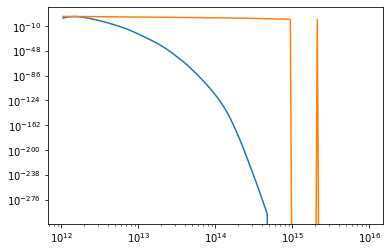

In [27]:
# q = np.load("current_optimizer.npy")
plot_params(q)

var:381.0806661353789
sim:[[18811.77779383]]
[[19192.85845997]]


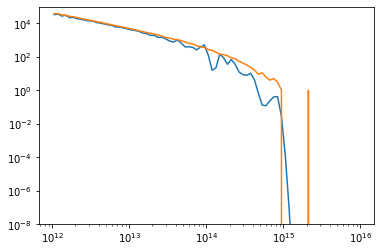

In [27]:

print(likelihood_total(q, overwrite=False))
_, res = get_HMF_piecewise(q[1:], reg_bins=79, Mpiv=1e14, offset=0)
N_model = integrate_dn_dlnM(res, False)
plt.loglog(np.logspace(12.025, 15.975, 80), N_model)
plt.loglog(np.power(10, X[:, 4]), Y)
plt.ylim(1e-8, 1e5)
plt.show()

var:381.0806661353789
sim:[[18811.77779383]]
[[19192.85845997]]


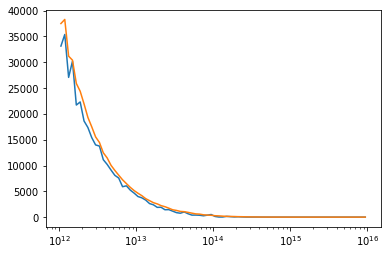

In [28]:

print(likelihood_total(q, overwrite=False))
_, res = get_HMF_piecewise(q[1:], reg_bins=79, Mpiv=1e14, offset=0)
N_model = integrate_dn_dlnM(res, False)
plt.plot(np.logspace(12.025, 15.975, 80), N_model)
plt.plot(np.power(10, X[:, 4]), Y)
plt.xscale("log")
# plt.ylim(1e-8, 1e5)
plt.show()

In [25]:
q[np.where(q > 0)] = -q[np.where(q > 0)]

In [26]:
q

array([-6.09004650e+01, -8.61621879e+02, -4.05485870e+02, -1.30476221e+02,
       -6.65176185e+01, -5.01670395e+01, -4.81640247e+01, -3.90614267e+01,
       -2.56399798e+01, -1.47888956e+01, -7.00145664e+00, -1.18360804e+00,
       -7.90133794e+00, -1.60134100e+01, -1.25284888e+01, -4.39446780e+00,
       -1.30706992e+00, -7.53566912e+00, -1.80217588e+01, -2.49491260e+01,
       -1.83545717e+01, -7.30988447e+00, -5.15750777e+00, -7.20177303e+00,
       -3.43605344e+00, -8.82290705e+00, -1.43414213e+01, -1.71524927e+01,
       -2.53326947e+01, -3.05524743e+01, -3.03218529e+01, -2.26085112e+01,
       -2.59678920e+00, -6.81897650e-01, -3.70080812e+01, -5.20334403e+01,
       -2.48317272e+00, -3.11855393e+01, -8.82879079e+00, -2.14479526e+01,
       -4.12994301e+01, -9.95079987e+00, -1.00061589e+02, -2.47641677e+01,
       -1.03887137e+02, -1.16296202e+02, -1.74024600e+02, -2.93016676e+00,
       -1.07779730e+02, -1.05344653e+02, -4.39398283e-01, -3.93492014e+01,
       -7.12983431e+00, -

In [85]:
Y_fit.shape

(1001, 26)

In [96]:
Y_fit[:, 2]

array([ -18.69873294,  -18.64393955,  -18.58919771, ..., -158.37886069,
       -158.67232716, -158.9662382 ])

In [66]:
A @ B @ C

array([[480., 480., 480., 480., 480., 480.],
       [480., 480., 480., 480., 480., 480.],
       [480., 480., 480., 480., 480., 480.]])

In [84]:
Y_fit.min()

-158.96623820005456

In [21]:
def f1(x):
    cost_raw = (x[0]-4) + (x[1]-4)
    cost_overrun = 0
    for el in x:
        if el >= 1.0:
            cost_overrun += (1000*(el-1))**8
        elif el <= 0.0:
            cost_overrun += (1000*(-el))**8

    return(cost_raw + cost_overrun)

qwe = optimize.basinhopping(f1, [1., 1.], niter=200)

In [22]:
qwe

                        fun: -8.000484678510782
 lowest_optimization_result:       fun: -8.000484678510782
 hess_inv: array([[ 3.99369238e-05, -5.04352880e-07],
       [-5.04352880e-07,  4.00658798e-05]])
      jac: array([0.0001862 , 0.00015533])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 436
      nit: 13
     njev: 106
   status: 2
  success: False
        x: array([-0.00027696, -0.00027696])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 153
                       nfev: 69680
                        nit: 200
                       njev: 17014
                          x: array([-0.00027696, -0.00027696])

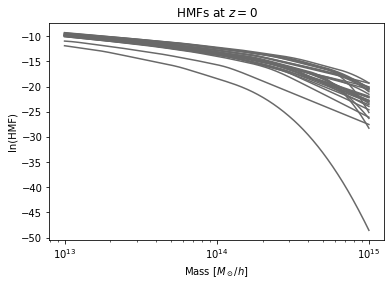

In [19]:
for i in range(Y_fit.shape[1]):
    plt.semilogx(np.logspace(13, 15, 1001), Y_fit[:, i], color='dimgrey')
plt.title("HMFs at $z = 0$")
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

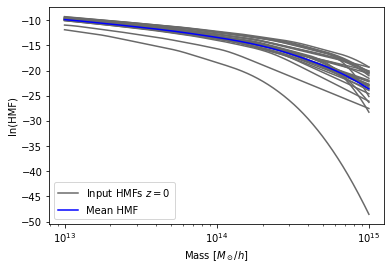

In [20]:
HMF_mean = np.average(Y_fit, axis=1).reshape(-1, 1)
for i in range(Y_fit.shape[1]):
    input_HMFs, = plt.semilogx(np.logspace(13, 15, 1001), Y_fit[:, i], color='dimgrey')
blue_line, = plt.semilogx(np.logspace(13, 15, 1001), HMF_mean, color='blue')


input_HMFs.set_label("Input HMFs $z = 0$")
blue_line.set_label("Mean HMF")
plt.legend(handles=[input_HMFs, blue_line], loc='lower left')
# plt.title("No outlier HMF")
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

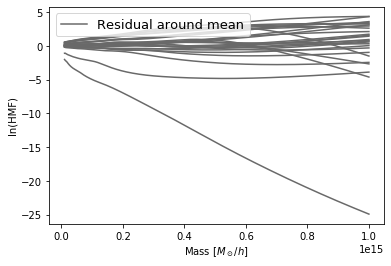

In [21]:
Y_res = Y_fit - np.broadcast_to(HMF_mean, (HMF_mean.size, 27))

for i in range(Y_res.shape[1]):
    residual_lines, = plt.plot(np.logspace(13, 15, 1001), Y_res[:, i], color='dimgrey')

    
residual_lines.set_label("Residual around mean")
plt.legend(handles=[residual_lines], loc='upper left', prop={'size': 13})
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

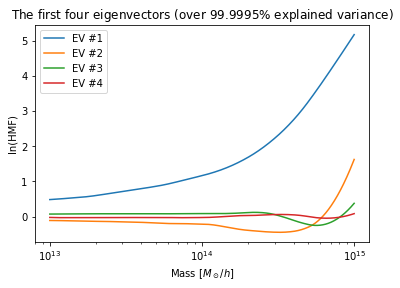

In [24]:
pca = Pca.calculate(Y_res)
pca.basis_vectors[:, :4]
handles = []
for i in range(4):
    globals()["evector" + str(i+1)], = plt.semilogx(np.logspace(13, 15, 1001), pca.basis_vectors[:, i])
    globals()["evector" + str(i+1)].set_label("EV #" + str(i+1))
    handles.append(globals()["evector" + str(i+1)])

plt.legend(handles=handles, loc='upper left')
plt.title("The first four eigenvectors (over $99.9995 \%$ explained variance)")
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

In [30]:
np.sum(pca.explained_variance[:1]) * 100

96.6685513208851

In [24]:
pca.explained_variance
var_sum = 0
for i in range(4):
    var_sum += pca.explained_variance[i]
explained_percentage = 100 * var_sum / np.sum(pca.explained_variance)
print("The first %d basis vectors explain %f %% of the variance." % (i+1, explained_percentage))

The first 4 basis vectors explain 99.999563 % of the variance.


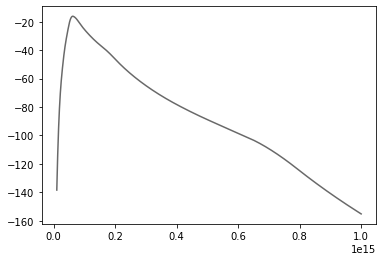

In [361]:
plt.plot(np.logspace(13, 15, 1001), Y_fit[:, 22], color='dimgrey')
plt.show()

In [16]:
import glob
import numpy as np
import os
import pickle
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.stats as stats
import sys
import time

from emulator import * 
from HMF_piecewise import *
from likelihood import *
from pca import *


def sort_data(X, Y):
    ''' Sorts input by mu_n, in ascending order.'''
    # Concatenate X and Y to make sorting easier.
    M = np.concatenate((X, Y), axis=1)
    M_new = M[M[:, 0].argsort()]

    # Sorting by mu_n messed up the order within each cosmology -
    # mass is no longer sorted in ascending order. This is fixed in the
    # for-loop below.
    for i in range(M_new.shape[0]//20):
        idx_lo = 20*i
        idx_hi = 20*(i+1)
        chunk = M_new[idx_lo:idx_hi]
        M_new[idx_lo:idx_hi] = chunk[chunk[:, 4].argsort()]

    X_new = M_new[:, :5]
    Y_new = np.expand_dims(M_new[:, 5], axis=1)

    return X_new, Y_new

a = HaloEmulator()
b = RedshiftTester(M_low=12, M_high=16)
print("Input shape: ", b.X.shape)

redshift = 0.
redshift_ind = np.where(b.X[:, 3] == redshift)
X = b.X[redshift_ind]
Y = b.Y[redshift_ind]
X, Y = sort_data(X, Y)

filelist = glob.glob('./hmf_params/*.npy')
filelist.sort()
filelist

# params = np.ones((26, 23))
# for i in range(len(filelist)):
#     # Skip file number 2.
#     if i < 2:
#         params[i] = np.load(filelist[i])
#     elif i == 2:
#         continue
#     else:
#         params[i-1] = np.load(filelist[i])

params = np.ones((27, 23))
for i in range(len(filelist)):
    params[i] = np.load(filelist[i])

ind_h, ind_v = np.where(params[:, 1:] > 0)
params[ind_h, ind_v+1] = 0

Mpiv = 1e14
M_arr_full = np.logspace(13, 15.5, 1001)


Y_fit = np.ones((1001, params.shape[0]))

for i in range(params.shape[0]):
    Y_fit[:, i], _ = get_HMF_piecewise(
        params[i][1:], reg_bins=19, offset=0, Mpiv=1e14)

Y_fit.shape

Input shape:(25640, 5)


(1001, 27)

In [17]:
import matplotlib.pyplot as plt

def check_n(n, log=False):
    plt.title("n = " + str(n))
    if log:
        plt.loglog(np.logspace(13.0625, 15.4375, 20), integrate_params(get_HMF_piecewise(np.load(filelist[n])[1:], reg_bins=19, offset=0, Mpiv=1e14)[1]))
        plt.loglog(np.logspace(13.0625, 15.4375, 20), Y[20*n:20*(n+1)])
    else:
        plt.semilogx(np.logspace(13.0625, 15.4375, 20), integrate_params(get_HMF_piecewise(np.load(filelist[n])[1:], reg_bins=19, offset=0, Mpiv=1e14)[1]))
        plt.semilogx(np.logspace(13.0625, 15.4375, 20), Y[20*n:20*(n+1)])
    plt.show()

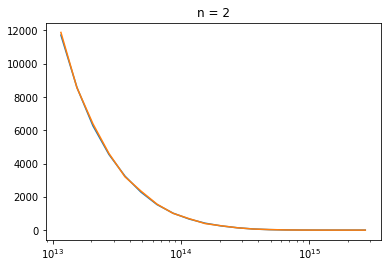

In [18]:
check_n(2)

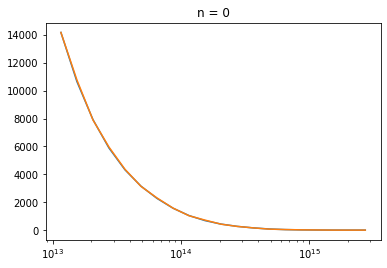

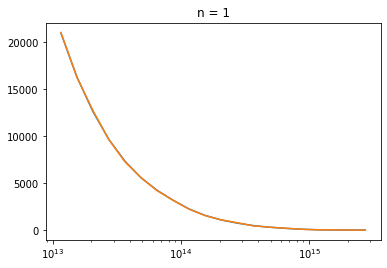

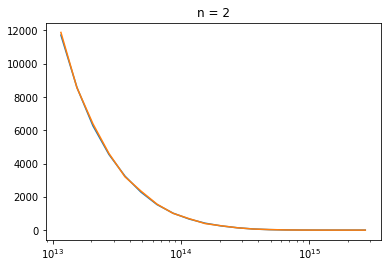

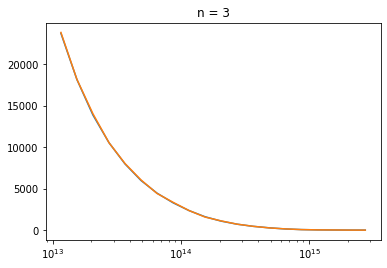

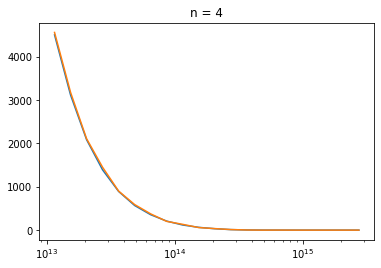

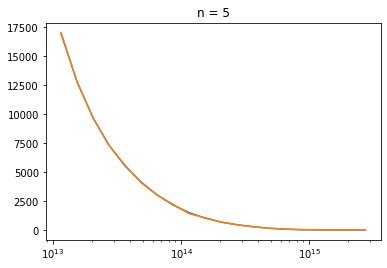

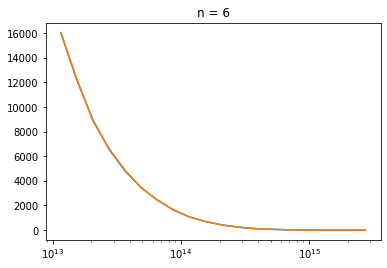

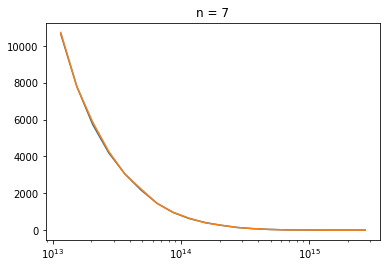

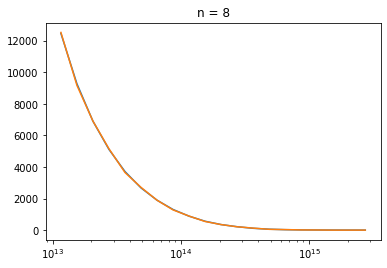

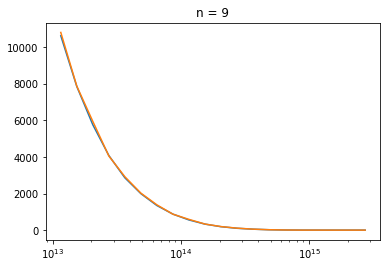

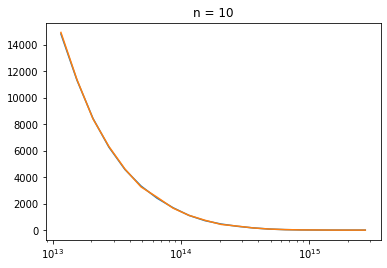

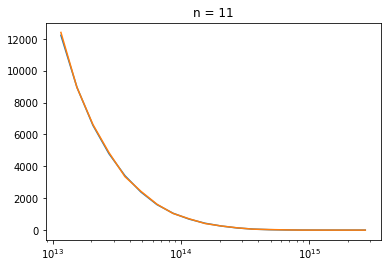

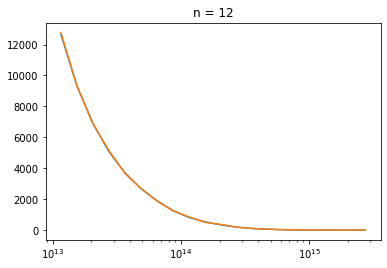

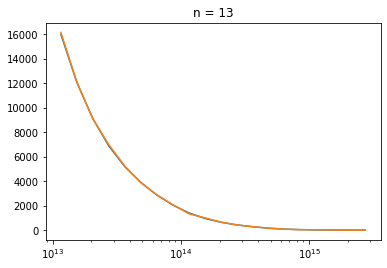

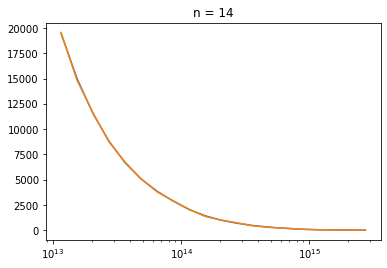

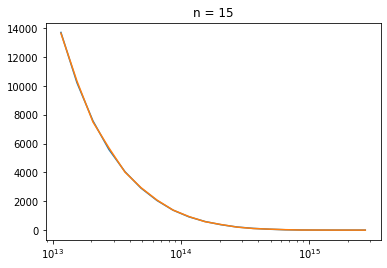

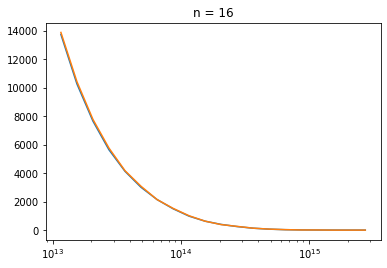

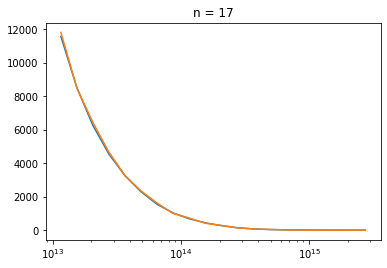

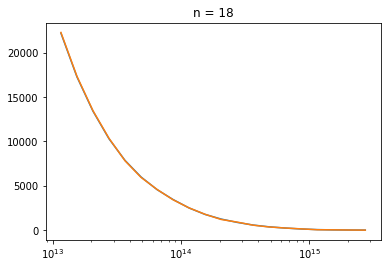

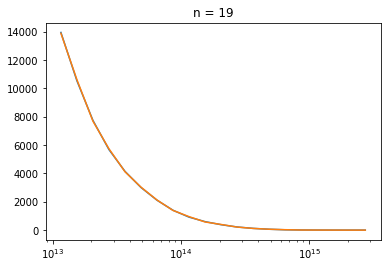

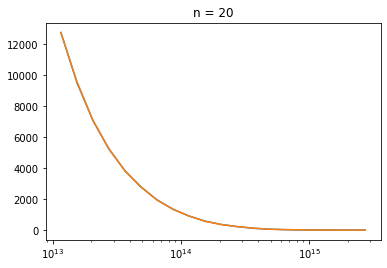

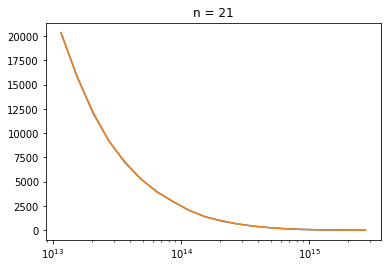

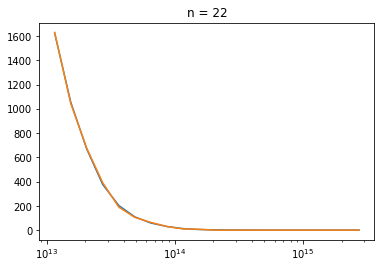

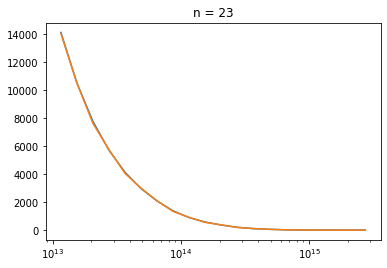

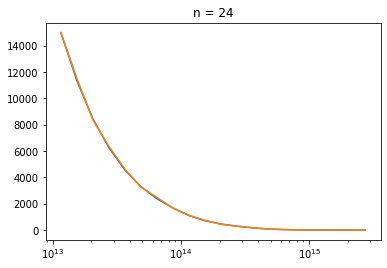

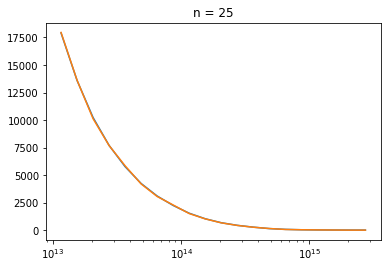

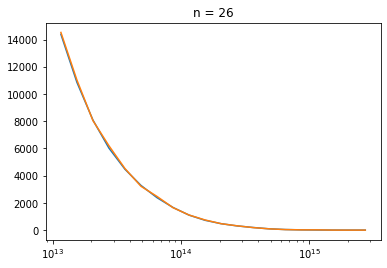

In [5]:
for n in range(27):
    check_n(n)

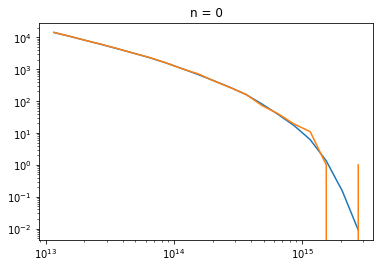

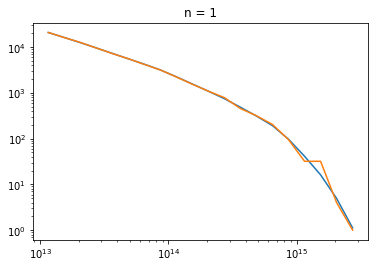

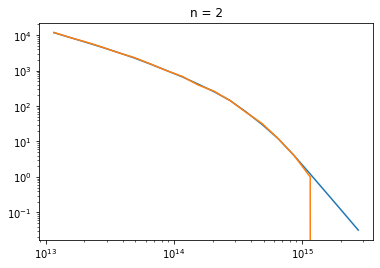

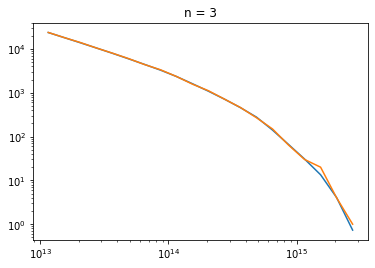

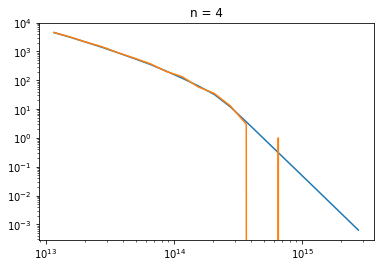

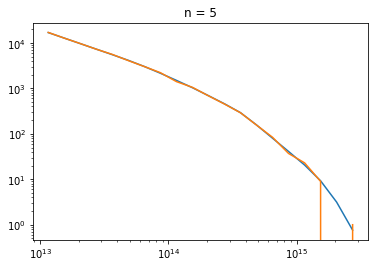

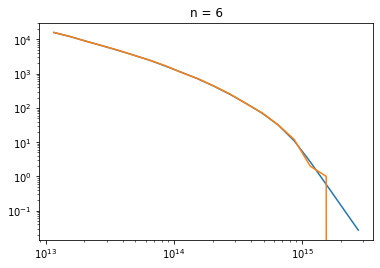

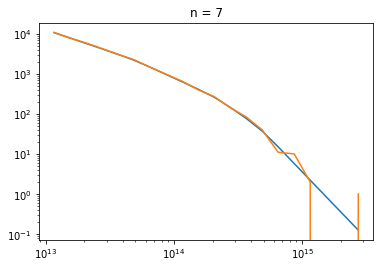

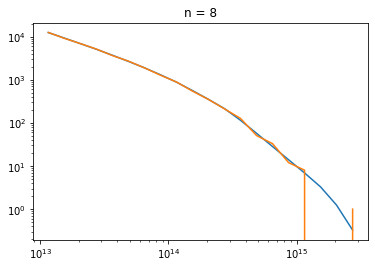

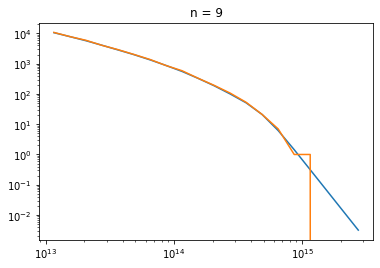

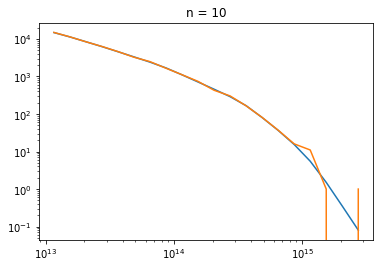

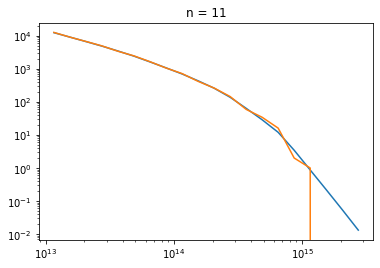

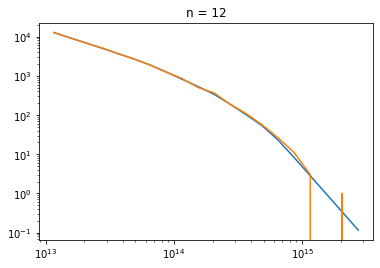

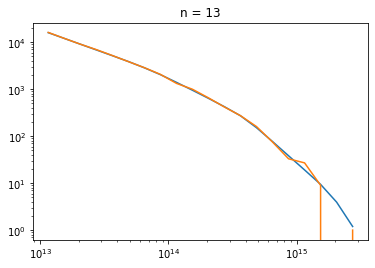

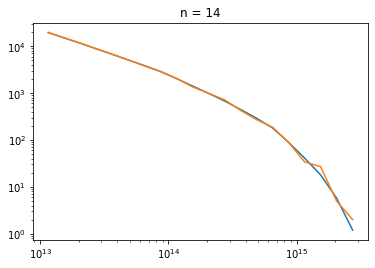

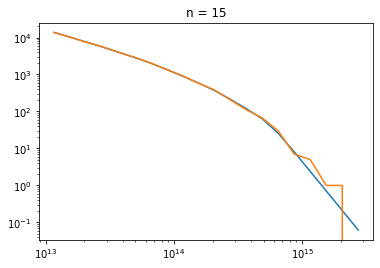

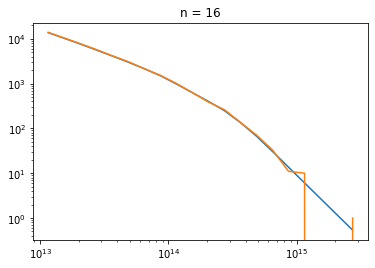

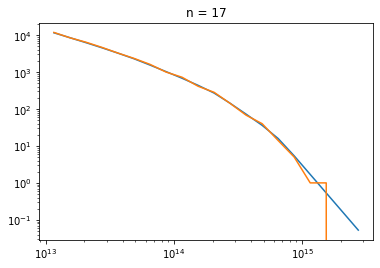

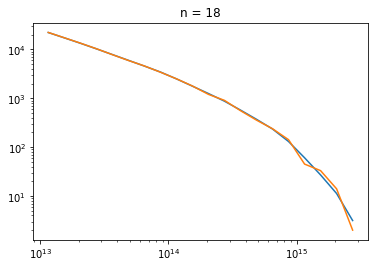

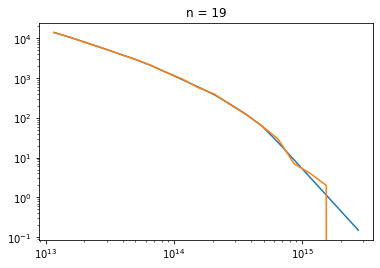

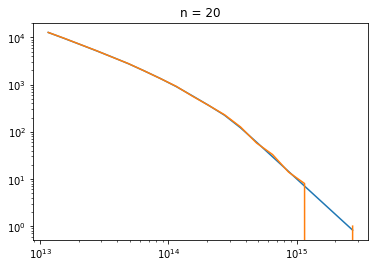

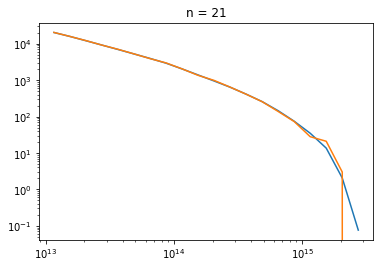

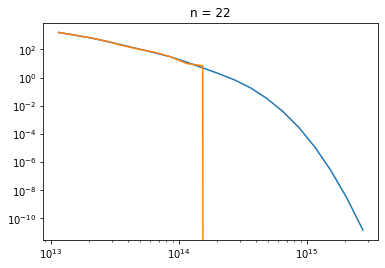

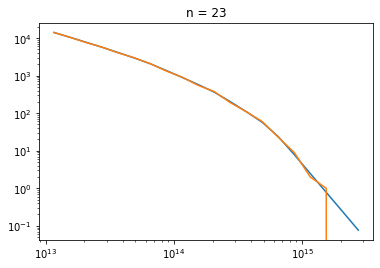

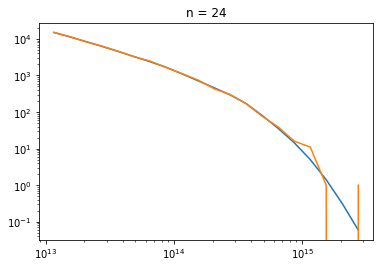

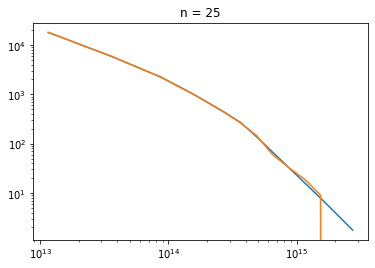

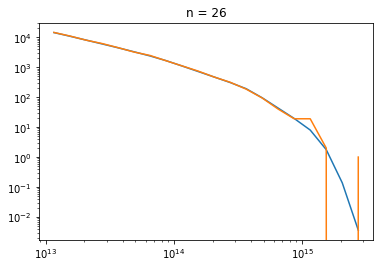

In [356]:
for n in range(27):
    check_n(n, log=True)

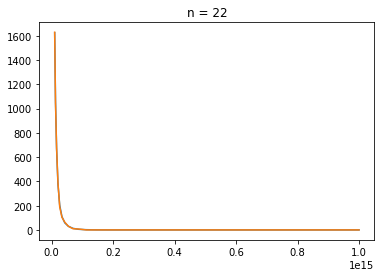

In [22]:
check_n(22)

In [1]:
q = np.load("../hmf_params/current_optimizer_0.11351_0.18409_1.7932.npy")
q.min()

NameError: name 'np' is not defined

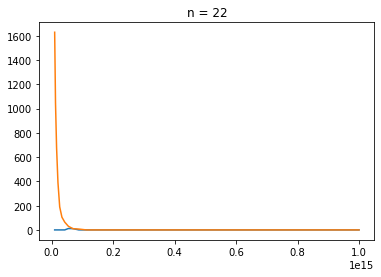

In [453]:
check_n(22)

In [460]:
q = np.load(filelist[22])
get_HMF_piecewise(q[1:], reg_bins=19, offset=0, Mpiv=1e14)[0]

array([-138.4595, -138.0164, -137.5734, ..., -153.9779, -154.6055,
       -155.2331])

In [51]:
Y_curr = Y[20*1:20*2]
C = load_cov_matrices("../covmat/covmat_M200c_mnu0.06522_om0.28205_As1.882620bins.pkl")[-1]
C, idx = remove_zeros(C)

Covariance matrix shape:(17, 17)


In [65]:
try:
    raise ValueError()
except ValueError:
    pass
print(1)

1


In [74]:
asdd = np.copy(q)
ind = np.where(asdd[1:] > 0)
ind

(array([ 1,  3,  5,  8, 13, 14, 16, 17, 18, 19, 20]),)

In [54]:
q = np.load("../hmf_params/current_optimizer_0.06522_0.28205_1.8826.npy")
likelihood_total(q, False)

[-12.08130126   6.11985035  -0.77777425  12.44718786 -15.44110389
   4.30209748  -7.15599614  -4.25854543   5.48070715 -16.47643208
 -19.98754818  -4.08227446 -12.07542098  10.64759011  10.33759379
 -18.01889632   1.07603853   9.48300202   3.03961353   8.38197796
  15.3319583   -6.70806322]
var:219.95334495108088
sim:[[1035398.41297755]]
[[7.51175788e+03]
 [2.80159814e+03]
 [2.86731675e+03]
 [9.02173863e+02]
 [2.26556531e+02]
 [2.94591100e+01]
 [1.94271470e+00]
 [1.56750442e-01]
 [2.73133640e-03]
 [2.80413528e-06]
 [5.44583735e-10]
 [2.58166697e-14]
 [1.54356273e-18]
 [5.01905486e-22]
 [5.61110028e-26]
 [2.12897713e-30]
 [2.20262451e-34]
 [5.91219460e-38]
 [4.76329247e-41]
 [3.10538216e-43]]
overrun:4.017870515339365e+33


array([[4.01787052e+33]])

In [323]:
redshift = 0.
redshift_ind = np.where(b.X[:, 3] == redshift)
X = b.X[redshift_ind]
Y = b.Y[redshift_ind]


qweqe = X[X[:, 0].argsort()]
for n in range(qweqe.shape[0]//20):
    qweqe_part = qweqe[20*n:20*(n+1)]
    qweqe[20*n:20*(n+1)] = qweqe_part[qweqe_part[:, 4].argsort()]
# qweqe[20:40] = qweqe[20:40][qweqe[20:40, 4].argsort()]
qweqe[:42]

array([[ 0.    ,  0.3   ,  2.1   ,  0.    , 13.0625],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.1875],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.3125],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.4375],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.5625],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.6875],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.8125],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 13.9375],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.0625],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.1875],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.3125],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.4375],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.5625],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.6875],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.8125],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 14.9375],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 15.0625],
       [ 0.    ,  0.3   ,  2.1   ,  0.    , 15.1875],
       [ 0.    ,  0.3   ,  2

In [ ]:
# n = 22
[-1.65368623e+01 -2.46580744e+00 -1.58424973e+00 -4.61882507e-01
 -4.25953913e-01 -1.54942700e-01 -2.33595595e-01 -1.29355599e-02
 -4.89200645e-01 -4.39973261e-01 -6.43198786e+00 -6.46839936e+00
 -1.89112117e+01 -1.10844939e+01 -1.25129210e+01 -1.11086934e+01
 -1.07922532e+01 -9.27401646e+00 -1.80734158e+01 -5.25058867e+00
 -6.39826643e+00 -1.74045514e+01]
var:  77.87039226627486
sim:  [[294.31901601]]

[-1.64737182e+01 -2.40815613e+00 -9.93290345e-02 -1.65634118e-03
 -9.01046648e-01 -1.19753144e-01 -2.21604517e-02 -1.94987043e-02
 -1.17309391e-01 -1.62692300e+00 -6.27227719e-02 -4.47823063e-01
 -2.50959790e+00 -2.83413887e+00 -3.18767130e+00 -1.58690369e+00
 -4.07162299e+00 -6.15281507e+00 -5.43207343e+00 -6.09920315e+00
 -3.53405643e+00 -4.82174894e+00]
var:  14.980540321080802
sim:  [[90.67257252]]

In [176]:
pca.basis_vectors[0]

array([ 9.84353507e+00, -7.83686052e-01,  1.92287490e-01, -4.89468734e-02,
       -8.38417691e-04, -4.65698042e-03, -1.79734052e-02, -6.23362264e-03,
        1.30539814e-02,  2.89807786e-03, -5.73717069e-03,  4.12544601e-03,
        5.46924854e-03,  5.60250460e-03,  8.03571470e-03,  3.27419532e-03,
       -5.06599653e-04,  4.09358296e-04, -4.73661603e-04, -5.27257462e-05,
       -4.38325405e-05,  2.07990451e-04,  1.06518042e-14, -2.30262088e-15,
        1.92121173e-14,  1.28891927e-14,  1.33685762e-14])

In [179]:
dasd = np.ones((4,))
wasd = [3,2,1,0]
np.inner(wasd, dasd)

6.0

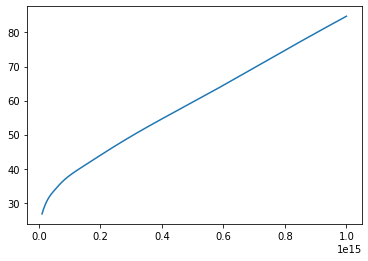

In [190]:
def pca_refit(weights):
    # Use the first four eigenvectors
    res = np.zeros((pca.basis_vectors.shape[0],))
    for i in range(4):
        res += weights[i] * pca.basis_vectors[:, i]
    return likelihood_total(res, overwrite=True)

plt.plot(np.logspace(13, 15, 1001), pca_refit([3,4,2,1]))
plt.show()

In [189]:
pca.basis_vectors[0].shape

(27,)

In [5]:
import random
random.uniform(0, 1)

def beta_s(w,a,b):
    return w**(a-1)*(1-w)**(b-1)

# This Function returns True if the coin with probability P of heads comes heads when flipped.
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

# This Function runs the MCMC chain for Beta Distribution.
def beta_mcmc(N_hops,a,b):
    states = []
    cur = random.uniform(0,1)
    for i in range(0,N_hops):
        states.append(cur)
        next = random.uniform(0,1)
        ap = min(beta_s(next,a,b)/beta_s(cur,a,b),1) # Calculate the acceptance probability
        if random_coin(ap):
            cur = next
    return states[-100:] # Returns the last 100 states of the chain

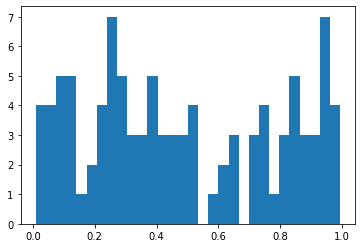

In [10]:
plt.hist(beta_mcmc(300, 1, 1), bins=30)
plt.show()

In [183]:
pca.u[:, 0].reshape(-1, 1) @ np.diagflat(pca.s[:1]).reshape(1, 1) @ pca.v[0, :].reshape(1, -1)

array([[-0.01644183,  0.38860524, -0.09874359, ...,  0.06168793,
         0.3111279 , -0.04071449],
       [-0.01646003,  0.38903556, -0.09885293, ...,  0.06175624,
         0.31147242, -0.04075958],
       [-0.01647835,  0.38946839, -0.09896291, ...,  0.06182495,
         0.31181896, -0.04080492],
       ...,
       [-0.17580958,  4.15528792, -1.05584789, ...,  0.65961828,
         3.32683621, -0.43535293],
       [-0.17626024,  4.16593919, -1.05855435, ...,  0.66130909,
         3.33536391, -0.43646887],
       [-0.17671105,  4.17659415, -1.06126175, ...,  0.66300048,
         3.34389456, -0.4375852 ]])

In [205]:
qwe = np.zeros((1001, 27))
for i in range(4):
    qwe += pca.s[i] * pca.u[:, i].reshape(-1, 1) @ pca.v[i, :].reshape(1, -1)
qwe

array([[ 0.06955759,  0.4612977 , -0.1156961 , ...,  0.13158173,
         0.28346525,  0.10155193],
       [ 0.06937852,  0.46149312, -0.11569314, ...,  0.13161283,
         0.28393618,  0.10160426],
       [ 0.06920878,  0.46169975, -0.11569539, ...,  0.13164756,
         0.28440413,  0.10166301],
       ...,
       [-2.7102439 ,  3.29296288,  0.00599331, ...,  0.24219768,
         4.25111739, -4.57834236],
       [-2.74914349,  3.29510367,  0.02004596, ...,  0.24100862,
         4.27314694, -4.64615393],
       [-2.78827689,  3.29722414,  0.03420176, ...,  0.23982052,
         4.2952572 , -4.71439961]])

In [206]:
pca.u[:, :4] @ np.diagflat(pca.s[:4]) @ pca.v[:4, :]

array([[ 0.06955759,  0.4612977 , -0.1156961 , ...,  0.13158173,
         0.28346525,  0.10155193],
       [ 0.06937852,  0.46149312, -0.11569314, ...,  0.13161283,
         0.28393618,  0.10160426],
       [ 0.06920878,  0.46169975, -0.11569539, ...,  0.13164756,
         0.28440413,  0.10166301],
       ...,
       [-2.7102439 ,  3.29296288,  0.00599331, ...,  0.24219768,
         4.25111739, -4.57834236],
       [-2.74914349,  3.29510367,  0.02004596, ...,  0.24100862,
         4.27314694, -4.64615393],
       [-2.78827689,  3.29722414,  0.03420176, ...,  0.23982052,
         4.2952572 , -4.71439961]])

In [289]:
X

array([[ 0.     ,  0.3    ,  2.1    ,  0.     , 13.0625 ],
       [ 0.     ,  0.3    ,  2.1    ,  0.     , 13.1875 ],
       [ 0.     ,  0.3    ,  2.1    ,  0.     , 13.3125 ],
       ...,
       [ 0.124  ,  0.30282,  2.3174 ,  0.     , 15.1875 ],
       [ 0.124  ,  0.30282,  2.3174 ,  0.     , 15.3125 ],
       [ 0.124  ,  0.30282,  2.3174 ,  0.     , 15.4375 ]])

In [293]:
np.log10(np.logspace(13, 15.5, 1001))[:101]

array([13.    , 13.0025, 13.005 , 13.0075, 13.01  , 13.0125, 13.015 ,
       13.0175, 13.02  , 13.0225, 13.025 , 13.0275, 13.03  , 13.0325,
       13.035 , 13.0375, 13.04  , 13.0425, 13.045 , 13.0475, 13.05  ,
       13.0525, 13.055 , 13.0575, 13.06  , 13.0625, 13.065 , 13.0675,
       13.07  , 13.0725, 13.075 , 13.0775, 13.08  , 13.0825, 13.085 ,
       13.0875, 13.09  , 13.0925, 13.095 , 13.0975, 13.1   , 13.1025,
       13.105 , 13.1075, 13.11  , 13.1125, 13.115 , 13.1175, 13.12  ,
       13.1225, 13.125 , 13.1275, 13.13  , 13.1325, 13.135 , 13.1375,
       13.14  , 13.1425, 13.145 , 13.1475, 13.15  , 13.1525, 13.155 ,
       13.1575, 13.16  , 13.1625, 13.165 , 13.1675, 13.17  , 13.1725,
       13.175 , 13.1775, 13.18  , 13.1825, 13.185 , 13.1875, 13.19  ,
       13.1925, 13.195 , 13.1975, 13.2   , 13.2025, 13.205 , 13.2075,
       13.21  , 13.2125, 13.215 , 13.2175, 13.22  , 13.2225, 13.225 ,
       13.2275, 13.23  , 13.2325, 13.235 , 13.2375, 13.24  , 13.2425,
       13.245 , 13.2

In [184]:
Y_res

array([[ 0.07306371,  0.458171  , -0.09349581, ...,  0.11331876,
         0.29821454,  0.07985285],
       [ 0.07329848,  0.45830614, -0.0945672 , ...,  0.11443832,
         0.29872852,  0.08055854],
       [ 0.07353031,  0.45845738, -0.09562249, ...,  0.11553723,
         0.29923832,  0.08125212],
       ...,
       [-2.60074506,  3.31096744,  0.01355104, ...,  0.309057  ,
         4.28818144, -4.487362  ],
       [-2.63456431,  3.31424248,  0.02790738, ...,  0.31115496,
         4.31203531, -4.5511222 ],
       [-2.66854791,  3.31752064,  0.04236935, ...,  0.31330398,
         4.33599754, -4.61527269]])

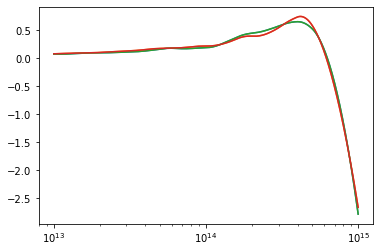

In [164]:
plt.semilogx(np.logspace(13, 15, 1001), y1[:, 0])
plt.semilogx(np.logspace(13, 15, 1001), Y_res[:, 0])
plt.show()

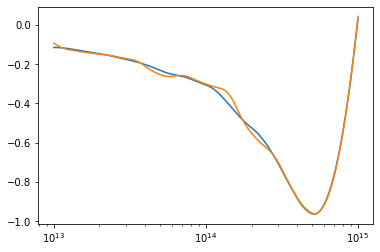

In [96]:
total = np.zeros((1001, 27))
for i in range(4):
    total += pca.s[i] * pca.u[:, i].reshape(-1, 1) @ pca.v[i, :].reshape(1, -1)
plt.semilogx(np.logspace(13, 15, 1001), total[:, 2])
plt.semilogx(np.logspace(13, 15, 1001), Y_res[:, 2])
plt.show()

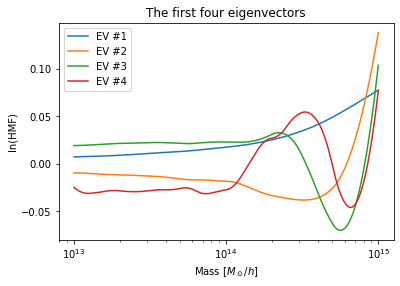

In [18]:
handles = []
for i in range(4):
    globals()["bvector" + str(i+1)], = plt.semilogx(np.logspace(13, 15, 1001), pca.u[:, i])
    globals()["bvector" + str(i+1)].set_label("EV #" + str(i+1))
    handles.append(globals()["bvector" + str(i+1)])

plt.legend(handles=handles, loc='upper left')
plt.title("The first four eigenvectors")
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

In [312]:
mean.shape

(1001, 1)

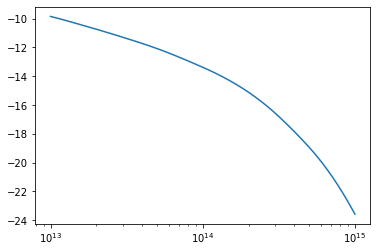

In [325]:
plt.semilogx(np.logspace(13, 15, 1001), mean.flatten() + pca.u[:, 0])
plt.show()

In [324]:
[(mean.flatten() + pca.u[:, 0]).shape]

[(1001,)]

In [331]:
pca.v.min()

-0.8574563205186213

In [97]:
for i in range(4):
    plt.semilogx(np.logspace(13, 15, 1001), mean.flatten() + pca.u[:, i])

plt.title("The first four u-basis vectors")
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

NameError: name 'mean' is not defined

In [305]:
integrate.trapz(pca.u[:, 0] / np.logspace(13, 15.5, 1001), np.logspace(13, 15.5, 1001))

0.1453198443841573

In [304]:
pca.u[:, 0] / np.logspace(13, 15.5, 1001)

array([7.20419444e-16, 7.17077460e-16, 7.13754707e-16, ...,
       2.46421099e-17, 2.45634687e-17, 2.44849400e-17])

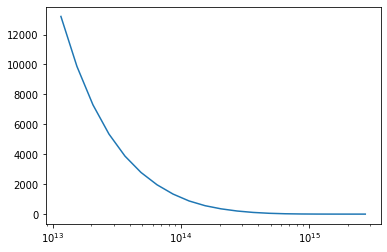

In [359]:
M_logspace = np.logspace(13, 15.5, 1001)
vals = np.zeros((20,))
for i in range(20):
    ind_lo = 50*i 
    ind_hi = 50*(i+1)+1
    x = M_logspace[ind_lo:ind_hi]
    dn_dlnM = np.e**(mean.flatten()[ind_lo:ind_hi] + pca.u[ind_lo:ind_hi, 0])
    y = 1e9 * dn_dlnM / x
    vals[i] = integrate.trapz(y, x)
plt.semilogx(np.logspace(13.0625, 15.4375, 20), vals)
plt.show()

In [350]:
np.log10(np.logspace(13.0625, 15.4375, 20))

array([13.0625, 13.1875, 13.3125, 13.4375, 13.5625, 13.6875, 13.8125,
       13.9375, 14.0625, 14.1875, 14.3125, 14.4375, 14.5625, 14.6875,
       14.8125, 14.9375, 15.0625, 15.1875, 15.3125, 15.4375])

In [103]:
u, s, v = scipy.linalg.svd(Y_fit, False)
S = np.zeros((27, 27))
np.fill_diagonal(S, s)

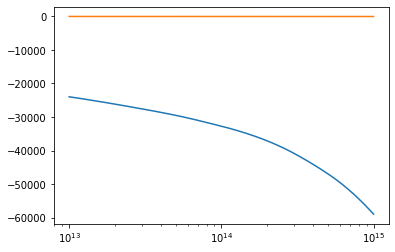

In [104]:
total1 = pca.basis_vectors @ S @ pca.weights
plt.semilogx(np.logspace(13, 15, 1001), total1[:, 0])
plt.semilogx(np.logspace(13, 15, 1001), Y_fit[:, 0])
plt.show()

In [272]:
import random
# Lets define our Beta Function to generate s for any particular state. We don't care for the normalizing constant here.
def beta_s(w,a,b):
    return w**(a-1)*(1-w)**(b-1)

# This Function returns True if the coin with probability P of heads comes heads when flipped.
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

# This Function runs the MCMC chain for Beta Distribution.
def beta_mcmc(N_hops,a,b):
    states = []
    acc = 0 
    tot = 0
    cur = random.uniform(0,1)
    for i in range(0,N_hops):
        states.append(cur)
        next = np.random.normal(cur, 0.01)
        ap = min(beta_s(next,a,b)/beta_s(cur,a,b),1) # Calculate the acceptance probability
        tot += 1
        if random_coin(ap):
            acc += 1
            cur = next
    print("Acceptance rate: %f" % (acc/tot))
    return states[-1000:] # Returns the last 100 states of the chain

Acceptance rate: 0.973690


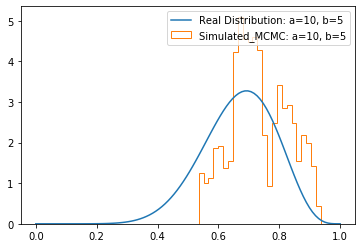

In [273]:

import scipy.special as ss

# Actual Beta PDF.
def beta(a, b, i):
    e1 = ss.gamma(a + b)
    e2 = ss.gamma(a)
    e3 = ss.gamma(b)
    e4 = i ** (a - 1)
    e5 = (1 - i) ** (b - 1)
    return (e1/(e2*e3)) * e4 * e5

# Create a function to plot Actual Beta PDF with the Beta Sampled from MCMC Chain.
def plot_beta(a, b):
    Ly = []
    Lx = []
    i_list = np.mgrid[0:1:100j]
    for i in i_list:
        Lx.append(i)
        Ly.append(beta(a, b, i))
    plt.plot(Lx, Ly, label="Real Distribution: a="+str(a)+", b="+str(b))
    plt.hist(beta_mcmc(100000,a,b),normed=True,bins =25, histtype='step',label="Simulated_MCMC: a="+str(a)+", b="+str(b))
    plt.legend()
    plt.show()
    plot_beta(10, 5)

In [591]:
# def fit_weights(weights, evectors):
#     res = np.zeros((1001,))
#     for i in range(len(weights)):
#         res += weights[i] * evectors[:, i]
#     return res

# # 20 bins.
# def integrate_dn_dlnM(HMF, n):
#     M_logspace = np.logspace(13, 15.5, 1001)
#     vals = np.zeros((20,1))
#     for i in range(20):
#         ind_lo = 50*i 
#         ind_hi = 50*(i+1)+1
#         x = M_logspace[ind_lo:ind_hi]
#         dn_dlnM = np.e**(mean.flatten()[ind_lo:ind_hi] + HMF[ind_lo:ind_hi])
#         y = 1e9 * dn_dlnM / x
#         vals[i] = integrate.trapz(y, x)
#     # plt.loglog(np.logspace(13.0625, 15.4375, 20), vals)
#     # plt.loglog(np.logspace(13.0625, 15.4375, 20), Y[20*n:20*(n+1)])
#     # plt.show()
#     return vals

# def load_cov_matrices(path):
#     pic_in = open(path, "rb")
#     cov_matrices = pickle.load(pic_in, encoding="latin1")

#     return cov_matrices

# def remove_zeros(C):
#     idx = np.argwhere(np.all(C == 0, axis=0) | np.all(C == 0, axis=1))
#     for i in idx[::-1]:
#         C = np.delete(C, i, axis=0)
#         C = np.delete(C, i, axis=1)
#     print("Covariance matrix shape: ", C.shape)
#     return C, idx

# def flip_coin(r):
#     u = np.random.uniform(0, 1)
#     if r > 1 or r > u:
#         return True
#     else:
#         return False


# def mcmc_step(N_hops, pca, std_dev=0.5, n=0):
#     filelist_mat = glob.glob("./covmat/covmat_M200c_*.pkl")
#     filelist_mat.sort()
#     filelist_mat
#     cov_matrices = load_cov_matrices(filelist_mat[n])[-1]

#     states = np.zeros((N_hops, 4))
#     acc = 0 
#     tot = 0 
#     cur = []
#     C, idx = remove_zeros(cov_matrices)
#     for i in range(4):
#         cur.append(np.random.uniform(0, 400))
    
#     for i in range(N_hops):
#         tot += 1

#         # if i % 100 == 0:
#         #     print("Cur: ", cur)
#         states[i] = cur
#         next = []
#         for j in range(4):
#             next.append(np.random.normal(cur[j], std_dev))

#         # if i % 100 == 0:
#         #     print(next)

#         HMF_cur = fit_weights(cur, pca.u[:, :4])
#         HMF_next = fit_weights(next, pca.u[:, :4])
#         N_cur = integrate_dn_dlnM(HMF_cur, 0)
#         N_next = integrate_dn_dlnM(HMF_next, 0)
#         log_likelihood_cur = -likelihood_sim(N_cur, Y[20*n:20*(n+1)], C, idx)
#         log_likelihood_next = -likelihood_sim(N_next, Y[20*n:20*(n+1)], C, idx)
#         if i % 100 == 0:
#             print(log_likelihood_cur)
#             print(log_likelihood_next)
#         lnR = log_likelihood_next - log_likelihood_cur
#         if flip_coin(np.e**lnR):
#             cur = next
#             acc += 1
    
#     print("Acceptance rate: %f" % (acc/tot))
#     return states[-1000:]

In [480]:
cur = []
next = []
N_hops = 1
for i in range(4):
    cur.append(random.uniform(0, 400))
    
for i in range(N_hops):
    next = []
    for j in range(4):
        next.append(np.random.normal(cur[j], 100))

HMF_cur = fit_weights(cur, pca.u[:, :4])
HMF_next = fit_weights(next, pca.u[:, :4])

In [12]:
def sort_data(X, Y):
    ''' Sorts input by mu_n, in ascending order.'''
    # Concatenate X and Y to make sorting easier.
    M = np.concatenate((X, Y), axis=1)
    M_new = M[M[:, 0].argsort()]

    # Sorting by mu_n messed up the order within each cosmology -
    # mass is no longer sorted in ascending order. This is fixed in the
    # for-loop below.
    for i in range(M_new.shape[0]//20):
        idx_lo = 20*i
        idx_hi = 20*(i+1)
        chunk = M_new[idx_lo:idx_hi]
        M_new[idx_lo:idx_hi] = chunk[chunk[:, 4].argsort()]

    X_new = M_new[:, :5]
    Y_new = np.expand_dims(M_new[:, 5], axis=1)

    return X_new, Y_new


a = HaloEmulator()
b = RedshiftTester(M_low=12, M_high=16)
print("Input shape: ", b.X.shape)

redshift = 0.
redshift_ind = np.where(b.X[:, 3] == redshift)
X = b.X[redshift_ind]
Y = b.Y[redshift_ind]
X, Y = sort_data(X, Y)

filelist = glob.glob('./hmf_params/*.npy')
filelist.sort()
filelist

# Params is a numpy array of shape (27, 23).
params = np.ones((len(filelist), 23))
for i in range(params.shape[0]):
    params[i] = np.load(filelist[i])


ind_h, ind_v = np.where(params[:, 1:] > 0)
params[ind_h, ind_v+1] = 0

Mpiv = 1e14

Y_fit = np.ones((1001, params.shape[0]))

for i in range(params.shape[0]):
    Y_fit[:, i], _ = get_HMF_piecewise(
        params[i][1:], reg_bins=19, offset=0, Mpiv=1e14)


# 1. Plot all HMF fits.
HMF_mean = np.average(Y_fit, axis=1).reshape(-1, 1)
# for i in range(Y_fit.shape[1]):
#     input_HMFs, = plt.semilogx(np.logspace(
#         13, 15.5, 1001), Y_fit[:, i], color='dimgrey')
#     blue_line, = plt.semilogx(np.logspace(
#         13, 15.5, 1001), HMF_mean, color='blue')


# input_HMFs.set_label("Input HMFs $z = 0$")
# blue_line.set_label("Mean HMF")
# plt.legend(handles=[input_HMFs, blue_line], loc='lower left')
# plt.xlabel("Mass [$M_\odot / h$]")
# plt.ylabel("ln(HMF)")
# plt.show()

# 2. Plot the residuals around the mean HMF.
Y_res = Y_fit - np.broadcast_to(HMF_mean, (HMF_mean.size, len(filelist)))
# for i in range(Y_res.shape[1]):
#     residual_lines, = plt.plot(np.logspace(
#         13, 15.5, 1001), Y_res[:, i], color='dimgrey')


# residual_lines.set_label("Residual around mean")
# plt.legend(handles=[residual_lines], loc='upper left', prop={'size': 13})
# plt.xlabel("Mass [$M_\odot / h$]")
# plt.ylabel("ln(HMF)")
# plt.show()

# 3. Conduct PCA and the first four plot eigenvectors.

pca = Pca.calculate(Y_res)
# pca.basis_vectors[:, :4]
# handles = []
# for i in range(4):
#     globals()["evector" + str(i+1)], = plt.semilogx(np.logspace(13,
#                                                                 15, 1001), pca.basis_vectors[:, i])
#     globals()["evector" + str(i+1)].set_label("EV #" + str(i+1))
#     handles.append(globals()["evector" + str(i+1)])

# plt.legend(handles=handles, loc='upper left')
# plt.title("The first four eigenvectors (over $99.9995 \%$ explained variance)")
# plt.xlabel("Mass [$M_\odot / h$]")
# plt.ylabel("ln(HMF)")
# plt.show()


var_sum = 0
for i in range(4):
    var_sum += pca.explained_variance[i]
explained_percentage = 100 * var_sum / np.sum(pca.explained_variance)
print("The first %d basis vectors explain %f %% of the variance." %
      (i+1, explained_percentage))


def fit_weights(weights, evectors):
    res = np.zeros((1001,))
    for i in range(len(weights)):
        res += weights[i] * evectors[:, i]
    return res


def integrate_dn_dlnM(HMF, n):
    # 20 bins.
    M_logspace = np.logspace(13, 15.5, 1001)
    vals = np.zeros((20, 1))
    for i in range(20):
        ind_lo = 50*i
        ind_hi = 50*(i+1)+1
        x = M_logspace[ind_lo:ind_hi]
        dn_dlnM = np.e**(HMF_mean.flatten()
                         [ind_lo:ind_hi] + HMF[ind_lo:ind_hi])
        y = 1e9 * dn_dlnM / x
        vals[i] = integrate.trapz(y, x)
    # plt.loglog(np.logspace(13.0625, 15.4375, 20), vals)
    # plt.loglog(np.logspace(13.0625, 15.4375, 20), Y[20*n:20*(n+1)])
    # plt.show()
    return vals


def load_cov_matrices(path):
    pic_in = open(path, "rb")
    cov_matrices = pickle.load(pic_in, encoding="latin1")

    return cov_matrices


def remove_zeros(C):
    idx = np.argwhere(np.all(C == 0, axis=0) | np.all(C == 0, axis=1))
    for i in idx[::-1]:
        C = np.delete(C, i, axis=0)
        C = np.delete(C, i, axis=1)
    print("Covariance matrix shape: ", C.shape)
    return C, idx


def flip_coin(r):
    u = np.random.uniform(0, 1)
    if r > 1 or r > u:
        return True
    else:
        return False


def mcmc_step(N_hops, pca, std_dev=0.5, n=0):
    # N_hops = 10000
    # std_dev = 0.5
    # n = 0
    filelist_mat = glob.glob("./covmat/covmat_M200c_*.pkl")
    filelist_mat.sort()
    filelist_mat
    cov_matrices = load_cov_matrices(filelist_mat[n])[-1]

    states = np.zeros((N_hops, 4))
    acc = 0
    tot = 0
    cur = []
    C, idx = remove_zeros(cov_matrices)
    for i in range(4):
        cur.append(np.random.uniform(0, 400))

    for i in range(N_hops):
        tot += 1

        # if i % 100 == 0:
        #     print("Cur: ", cur)
        states[i] = cur
        next = []
        for j in range(4):
            next.append(np.random.normal(cur[j], std_dev))

        # if i % 100 == 0:
        #     print(next)

        HMF_cur = fit_weights(cur, pca.u[:, :4])
        HMF_next = fit_weights(next, pca.u[:, :4])
        N_cur = integrate_dn_dlnM(HMF_cur, 0)
        N_next = integrate_dn_dlnM(HMF_next, 0)
        log_likelihood_cur = -likelihood_sim(N_cur, Y[20*n:20*(n+1)], C, idx)
        log_likelihood_next = -likelihood_sim(N_next, Y[20*n:20*(n+1)], C, idx)
        if i % 100 == 0:
            print(log_likelihood_cur)
            print(log_likelihood_next)
        lnR = log_likelihood_next - log_likelihood_cur
        if flip_coin(np.e**lnR):
            cur = next
            acc += 1

    print("Acceptance rate: %f" % (acc/tot))
    return states[-10000:]


# tic = time.perf_counter()
# states = mcmc_step(N_hops=1000, pca=pca, std_dev=0.5, n=0)
# toc = time.perf_counter()
# print(states[-1000:])
# print("Time: %f seconds." % (toc-tic))

Input shape:  (25640, 5)
The first 4 basis vectors explain 99.981052 % of the variance.


In [14]:
states = np.load("mcmc_states.npy")

In [21]:
states[-100:]

array([[ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.33452388, -2.14456635,  0.5687125 ],
       [ 8.66823949, -7.

In [554]:
C, idx = remove_zeros(load_cov_matrices(filelist_mat[0])[-1])

cur = []
for i in range(4):
    cur.append(random.uniform(0, 400))

HMF_cur = fit_weights(states[-1], pca.u[:, :4])
N_cur = integrate_dn_dlnM(HMF_cur, 0)
likelihood_sim(N_cur, Y[:20], C, idx)

Covariance matrix shape:(19, 19)


array([[inf]])

In [640]:
states1 = mcmc_step(N_hops=1000000, pca=pca, std_dev=0.5, n=0)

array([ 8.26616473, -7.29417982, -2.35961822,  0.38969151])

In [644]:
states[-1]

array([ 8.26616473, -7.29417982, -2.35961822,  0.38969151])

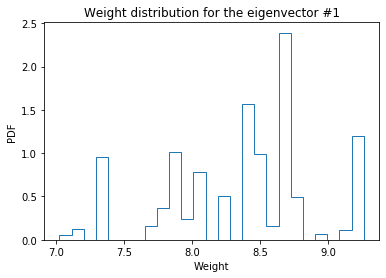

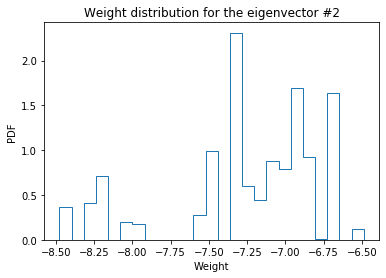

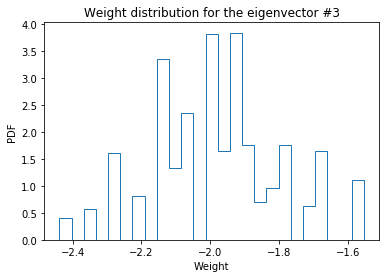

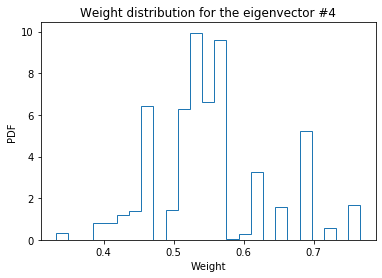

In [15]:
for i in range(4):
    plt.hist(states[:, i],normed=True,bins =25, histtype='step')
    plt.title("Weight distribution for the eigenvector #%d" % (i+1))
    plt.xlabel("Weight")
    plt.ylabel("PDF")
    plt.show()

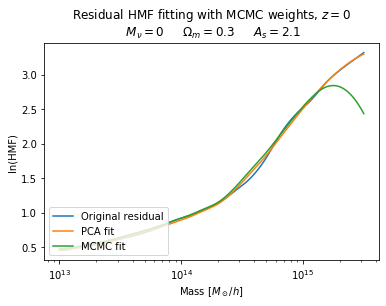

In [75]:
# def fit_weights(weights, evectors):
#     res = np.zeros((1001,))
#     for i in range(len(weights)):
#         res += weights[i] * evectors[:, i]
#     return res

# qwe = [3.99161182, 2.36232795, 4.39837263, 2.33116345]

# MCMC_fit, = plt.semilogx(np.logspace(13, 15.5, 1001), fit_weights(states[-1], pca.u))
original_fit, = plt.semilogx(np.logspace(13, 15.5, 1001), Y_res[:, 1])
# plt.semilogx(np.logspace(13, 15.5, 1001), asd)
pca_fit, = plt.semilogx(np.logspace(13, 15.5, 1001), fit_weights(pca.v[:4, 1], pca.u @ np.diagflat(pca.s)))
mcmc_fit, = plt.semilogx(np.logspace(13, 15.5, 1001), fit_weights([51, -12, 0.8, 0.75], pca.u))
# plt.semilogx(np.logspace(13, 15.5, 1001), fit_weights(qwe, pca.u))
plt.title("Residual HMF fitting with MCMC weights, $z=0$ \n $M_{\\nu}=0.$     $\Omega_m=0.3$     $A_s=2.1$")

pca_fit.set_label("PCA fit")
original_fit.set_label("Original residual")
mcmc_fit.set_label("MCMC fit")


plt.legend(handles=[original_fit, pca_fit, mcmc_fit], loc="lower left")
plt.xlabel("Mass [$M_\odot / h$]")
plt.ylabel("ln(HMF)")
plt.show()

In [45]:
pca.weights.shape

(27, 27)

In [425]:
def flip_coin(r):
    u = np.random.uniform(0, 1)
    if r > 1 or r > u:
        return True
    else:
        return False

In [362]:
filelist

['./hmf_params/current_optimizer_0.00000_0.30000_2.1000.npy',
 './hmf_params/current_optimizer_0.06271_0.38154_2.2004.npy',
 './hmf_params/current_optimizer_0.06522_0.28205_1.8826.npy',
 './hmf_params/current_optimizer_0.06773_0.41591_1.6231.npy',
 './hmf_params/current_optimizer_0.07024_0.20235_2.3075.npy',
 './hmf_params/current_optimizer_0.07275_0.32826_2.2883.npy',
 './hmf_params/current_optimizer_0.07526_0.33551_1.5659.npy',
 './hmf_params/current_optimizer_0.07778_0.25966_2.4333.npy',
 './hmf_params/current_optimizer_0.08030_0.27832_2.3824.npy',
 './hmf_params/current_optimizer_0.08282_0.27575_1.8292.npy',
 './hmf_params/current_optimizer_0.08535_0.31316_1.9913.npy',
 './hmf_params/current_optimizer_0.08788_0.29264_1.7376.npy',
 './hmf_params/current_optimizer_0.09041_0.28447_2.1757.npy',
 './hmf_params/current_optimizer_0.09295_0.31553_2.4949.npy',
 './hmf_params/current_optimizer_0.09550_0.35898_2.4624.npy',
 './hmf_params/current_optimizer_0.09805_0.30056_1.9744.npy',
 './hmf_

In [407]:
filelist_mat = glob.glob("./covmat/covmat_M200c_*.pkl")
filelist_mat.sort()
filelist_mat

['./covmat/covmat_M200c_mnu0.00000_om0.30000_As2.100020bins.pkl',
 './covmat/covmat_M200c_mnu0.06271_om0.38154_As2.200420bins.pkl',
 './covmat/covmat_M200c_mnu0.06522_om0.28205_As1.882620bins.pkl',
 './covmat/covmat_M200c_mnu0.06773_om0.41591_As1.623120bins.pkl',
 './covmat/covmat_M200c_mnu0.07024_om0.20235_As2.307520bins.pkl',
 './covmat/covmat_M200c_mnu0.07275_om0.32826_As2.288320bins.pkl',
 './covmat/covmat_M200c_mnu0.07526_om0.33551_As1.565920bins.pkl',
 './covmat/covmat_M200c_mnu0.07778_om0.25966_As2.433320bins.pkl',
 './covmat/covmat_M200c_mnu0.08030_om0.27832_As2.382420bins.pkl',
 './covmat/covmat_M200c_mnu0.08282_om0.27575_As1.829220bins.pkl',
 './covmat/covmat_M200c_mnu0.08535_om0.31316_As1.991320bins.pkl',
 './covmat/covmat_M200c_mnu0.08788_om0.29264_As1.737620bins.pkl',
 './covmat/covmat_M200c_mnu0.09041_om0.28447_As2.175720bins.pkl',
 './covmat/covmat_M200c_mnu0.09295_om0.31553_As2.494920bins.pkl',
 './covmat/covmat_M200c_mnu0.09550_om0.35898_As2.462420bins.pkl',
 './covmat

In [414]:
def load_cov_matrices(path):
    pic_in = open(path, "rb")
    cov_matrices = pickle.load(pic_in, encoding="latin1")

    return cov_matrices

In [417]:
cov_matrices = load_cov_matrices(filelist_mat[0])[-1]
cov_matrices.shape

(20, 20)

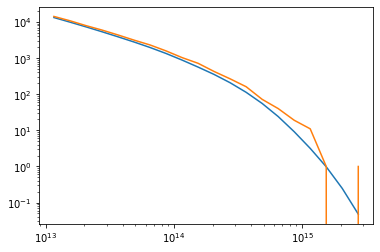

In [380]:
integrate_dn_dlnM(fit_weights(pca.s[:4], pca.u[:, :4])[:0], 0)

In [409]:
X[::20]

array([[ 0.     ,  0.3    ,  2.1    ,  0.     , 13.0625 ],
       [ 0.06271,  0.38154,  2.2004 ,  0.     , 13.0625 ],
       [ 0.06522,  0.28205,  1.8826 ,  0.     , 13.0625 ],
       [ 0.06773,  0.41591,  1.6231 ,  0.     , 13.0625 ],
       [ 0.07024,  0.20235,  2.3075 ,  0.     , 13.0625 ],
       [ 0.07275,  0.32826,  2.2883 ,  0.     , 13.0625 ],
       [ 0.07526,  0.33551,  1.5659 ,  0.     , 13.0625 ],
       [ 0.07778,  0.25966,  2.4333 ,  0.     , 13.0625 ],
       [ 0.0803 ,  0.27832,  2.3824 ,  0.     , 13.0625 ],
       [ 0.08282,  0.27575,  1.8292 ,  0.     , 13.0625 ],
       [ 0.08535,  0.31316,  1.9913 ,  0.     , 13.0625 ],
       [ 0.08788,  0.29264,  1.7376 ,  0.     , 13.0625 ],
       [ 0.09041,  0.28447,  2.1757 ,  0.     , 13.0625 ],
       [ 0.09295,  0.31553,  2.4949 ,  0.     , 13.0625 ],
       [ 0.0955 ,  0.35898,  2.4624 ,  0.     , 13.0625 ],
       [ 0.09805,  0.30056,  1.9744 ,  0.     , 13.0625 ],
       [ 0.1    ,  0.3    ,  2.1    ,  0.     , 13.0625 

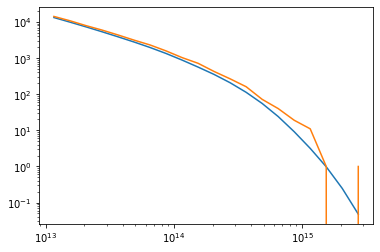

In [399]:
plt.loglog(np.logspace(13.0625, 15.4375, 20), integrate_dn_dlnM((pca.u[:, :4] @ np.diagflat(pca.s[:4]) @ pca.v[:4])[:, 0], 0))
plt.loglog(np.logspace(13.0625, 15.4375, 20), Y[:20])
plt.show()

In [385]:
pca.u[:, 4].shape

(1001,)

In [612]:
mean

array([[ -9.86403084],
       [ -9.86920505],
       [ -9.87439535],
       ...,
       [-23.57274972],
       [-23.61167806],
       [-23.65071476]])

In [636]:
qwe = [ 7.89409515, -6.79239809, -1.28465917,  0.77826924]
-likelihood_sim(integrate_dn_dlnM(fit_weights(qwe, pca.u[:, :4]), 0), Y[20*n:20*(n+1)], C, idx)

array([[-290.70871298]])

In [635]:
qwe1 = [ 7.79396988, -7.05634761, -1.53230734,  0.69524743]
-likelihood_sim(integrate_dn_dlnM(fit_weights(qwe1, pca.u[:, :4]), 0), Y[20*n:20*(n+1)], C, idx)

array([[-289.18562975]])

In [641]:
-likelihood_sim(integrate_dn_dlnM(fit_weights(states[-1], pca.u[:, :4]), 0), Y[20*n:20*(n+1)], C, idx)

array([[-290.85460577]])

In [631]:
integrate_dn_dlnM(fit_weights(qwe, pca.u[:, :4]), 0)

array([[1.41695305e+04],
       [1.06634427e+04],
       [7.96463402e+03],
       [5.88060347e+03],
       [4.30657087e+03],
       [3.13369720e+03],
       [2.24817224e+03],
       [1.56886866e+03],
       [1.03870568e+03],
       [6.75299390e+02],
       [4.34387858e+02],
       [2.73230425e+02],
       [1.60086256e+02],
       [8.29760637e+01],
       [3.88355248e+01],
       [1.60624705e+01],
       [5.80535707e+00],
       [1.68386195e+00],
       [3.37850733e-01],
       [4.35790175e-02]])

In [633]:
n = 0

In [648]:
np.save("mcmc_states", states)

In [2]:
import emcee
import numpy as np 

def log_prob(x, mu, cov):
    diff = x - mu 
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [18]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [21]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [25]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

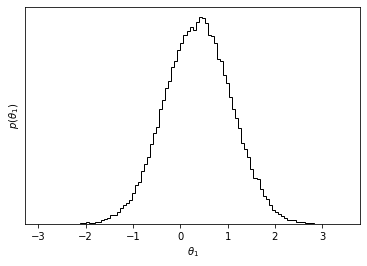

Mean acceptance fraction: 0.553


In [51]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([])
plt.show()
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

In [55]:
np.mean(sampler.acceptance_fraction)

0.5527844772777533

In [46]:
sampler.get_chain().shape

(36176, 32, 5)

In [101]:
pca.s

array([3.47177564e+02, 6.11974263e+01, 1.88315505e+01, 5.52047480e+00,
       3.36913852e+00, 2.78600271e+00, 1.35330420e+00, 1.09137602e+00,
       6.79695861e-01, 6.53919965e-01, 4.30129433e-01, 4.21602563e-01,
       3.16386870e-01, 2.46756217e-01, 1.86563663e-01, 1.47781903e-01,
       9.34437155e-02, 7.93300701e-02, 6.04351587e-02, 4.10642430e-02,
       1.21033974e-02, 8.05722432e-03, 2.80592946e-13, 3.52729842e-14,
       3.28611056e-14, 3.26440583e-14, 3.15629122e-14])

In [84]:
a = np.array([[10, 7, 4], [4, 2, 1]])
np.percentile(a, 75, axis=0)

array([8.5 , 5.75, 3.25])

In [210]:
def log_likelihood_mcmc(weights, y):
    filelist_mat = glob.glob("./covmat/covmat_M200c_*.pkl")
    filelist_mat.sort()
    filelist_mat
    cov_matrix = load_cov_matrices(filelist_mat[0])[-1]
    C, idx = remove_zeros(cov_matrix)

    HMF_weights = fit_weights(weights, pca.u)
    N_weights = integrate_dn_dlnM(y, 0)
    N_y = integrate_dn_dlnM(y, 0)

    return -likelihood_sim(N_weights, N_y, C, idx)

In [121]:
log_likelihood_mcmc([ 8.4, -7.35, -2.,  0.55826924])

Covariance matrix shape:(19, 19)


array([[-288.13524017]])

In [162]:
log_likelihood_mcmc(np.dot(np.diagflat(pca.s), pca.v)[:4, 0])

Covariance matrix shape:(19, 19)


array([[-395.6857745]])

In [208]:
def log_prior(weights):
    for w in weights:
        if -700.0 < w < 700.0:
            return 0.0
    return -np.inf

def log_probability(weights, **kwargs):
    y = kwargs['y']
    lp = log_prior(weights)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_mcmc(weights, y)

In [204]:
log_probability(initial_weights, y=Y_res[:, 0])

NameError: name 'log_likelihood' is not defined

In [209]:
import emcee

ndim = 4
n_walkers = 32

initial_weights = np.dot(np.diagflat(pca.s), pca.v)[:4, 0]
p0 = np.broadcast_to(initial_weights, (n_walkers, initial_weights.size))
pos =  + 1e-4 * np.random.randn(n_walkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, kwargs=({'y': Y_res[:, 0]}))
sampler.run_mcmc(pos, 5000, progress=True)

Covariance matrix shape:(19, 19)
emcee: Exception while calling your likelihood function:
  params:[ 9.03934841e-05 -2.36293244e-04 -1.00973070e-04  6.19154261e-05]
  args:[]
  kwargs:{'y': array([ 0.07306371,  0.07329848,  0.07353031, ..., -2.60074506,
       -2.63456431, -2.66854791])}
  exception:
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-208-eb5bad836617>", line 12, in log_probability
    return lp + log_likelihood_mcmc(weights, y)
  File "<ipython-input-175-710eb37827aa>", line 9, in log_likelihood_mcmc
    N_weights = integrate_dn_dlnM(HMF, 0)
NameError: name 'HMF' is not defined


NameError: name 'HMF' is not defined

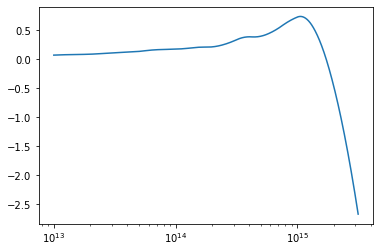

In [186]:
plt.semilogx(np.logspace(13, 15.5, 1001), Y_res[:, 0])
plt.show()

In [173]:
np.dot(np.diagflat(pca.s), pca.v)[:4]

-297.6895967218476

In [159]:
integrate_dn_dlnM(asd, 0)

array([[1.40446885e+04],
       [1.05927730e+04],
       [7.91638356e+03],
       [5.81529575e+03],
       [4.24293193e+03],
       [3.08025253e+03],
       [2.22482178e+03],
       [1.56421702e+03],
       [1.02300000e+03],
       [6.58593390e+02],
       [4.23224948e+02],
       [2.74425858e+02],
       [1.65481378e+02],
       [8.53936437e+01],
       [3.98186664e+01],
       [1.64308519e+01],
       [5.61192309e+00],
       [1.32557837e+00],
       [1.63201237e-01],
       [9.17309830e-03]])

In [70]:
import matplotlib.ticker as ticker

# %matplotlib inline
samples = np.load("ewq0.npy")

fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ["$w_1$", "$w_2$", "$w_3$", "$w_4$"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

# axes[-1].xaxis.set_major_locator(ticker.MultipleLocator(100))

axes[-1].set_xlabel("step number")
# plt.savefig("mcmc1.png", dpi=320)
# axes[0].set_title("MCMC on the weights")
plt.show()

IndexError: too many indices for array

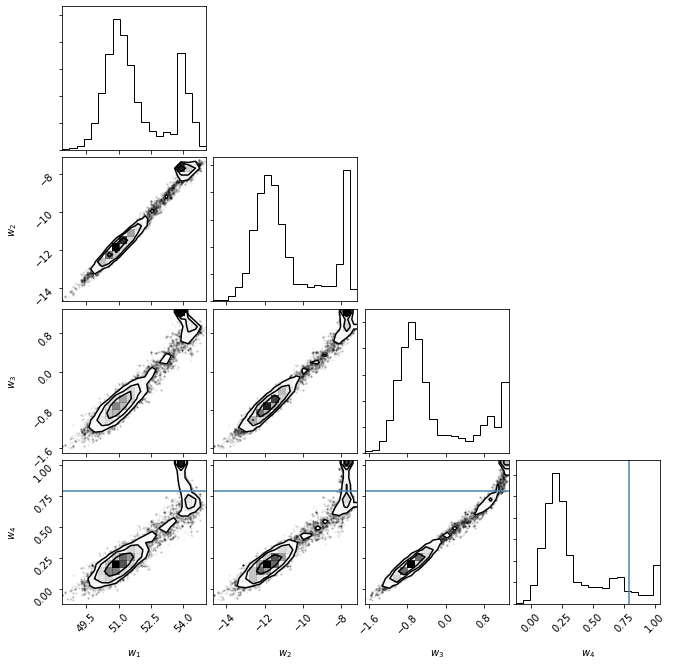

In [72]:
import corner

# %matplotlib inline

flat_samples = np.load("ewq1.npy")

fig = corner.corner(
    flat_samples, labels=labels, truths=np.dot(np.diagflat(pca.s), pca.v)[:4, 0]
)

# plt.savefig("corner.png", dpi=320)
plt.show()

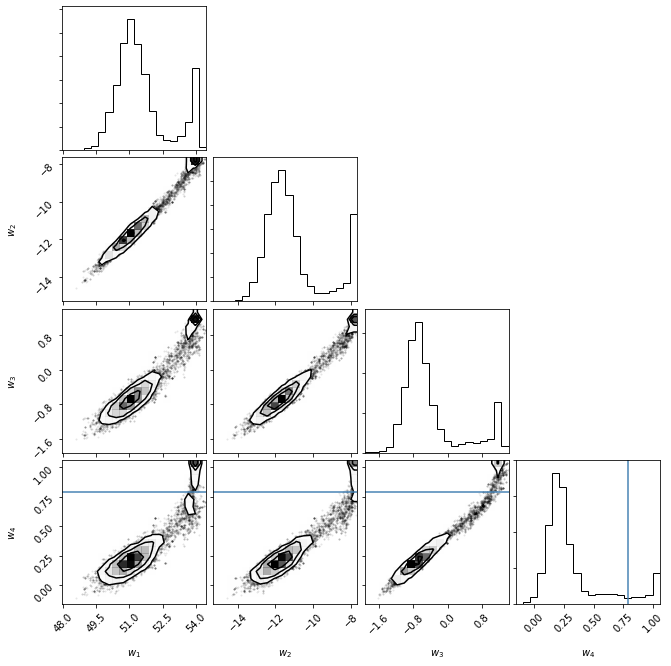

In [77]:
import corner

# %matplotlib inline

flat_samples = np.load("samples_no_tau_1.npy")

fig = corner.corner(
    flat_samples, labels=labels, truths=np.dot(np.diagflat(pca.s), pca.v)[:4, 0]
)

# plt.savefig("corner.png", dpi=320)
plt.show()

In [44]:
from mcmc import *

print(log_likelihood_mcmc([9.3, -5.8, -1.2, 0.8], Y_res[:, 0])[0, 0])
print(log_likelihood_mcmc(np.dot(np.diagflat(pca.s), pca.v)[:4, 0], Y_res[:, 0])[0, 0])

-31.055670568295447
-154.48329845895375


In [69]:
np.round(253, -2)

300

In [31]:
def integrate_dn_dlnM(HMF, n):
    '''Integrates the given HMF for a given cosmology. The cosmology is 
    provided by the number in the (sorted) list of cosmologies, starting at 
    [0., 0.3, 2.1].'''
    # 20 bins.
    M_logspace = np.logspace(13, 15.5, 1001)
    vals = np.zeros((20, 1))
    for i in range(20):
        ind_lo = 50*i
        ind_hi = 50*(i+1)+1
        x = M_logspace[ind_lo:ind_hi]
        dn_dlnM = np.e**(HMF[ind_lo:ind_hi])
        y = 1e9 * dn_dlnM / x
        vals[i] = integrate.trapz(y, x)
    return vals

def log_likelihood_mcmc(weights, y):
    filelist_mat = glob.glob("./covmat/covmat_M200c_*.pkl")
    filelist_mat.sort()
    filelist_mat
    cov_matrix = load_cov_matrices(filelist_mat[0])[-1]
    C, idx = remove_zeros(cov_matrix)

    N_weights = integrate_dn_dlnM(
        HMF_mean[:, 0] + fit_weights(weights, pca.u), 0)
    N_y = integrate_dn_dlnM(HMF_mean[:, 0] + y, 0)

    return -likelihood_sim(N_weights, N_y, C, idx)

qwe = [-604.91238725, -103.13189855, -345.14185781, -364.00705198]
log_likelihood_mcmc(qwe, Y_res[:, 0])

NameError: name 'load_cov_matrices' is not defined

In [58]:
exp = np.mean(np.load("mcmc_states.npy"), axis=0)
exp

array([ 8.35531317, -7.25413217, -1.97642066,  0.55282217])

In [59]:
theo = np.mean(np.load("mcmc_samples1_flat.npy"), axis=0)
theo

array([ 9.60801729, -5.23524676, -1.1029703 ,  0.81197363])

In [57]:
100 * np.abs(exp - theo) / theo

array([ 13.03811265, -38.56332864, -79.19074162,  31.91624083])

In [102]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, kwargs=({'y': Y_res[:, 0]}))
sampler.run_mcmc(pos, 5000, progress=True)

]Calculated.  [[-35.79932767]]
[10.14609176 -5.14832949 -1.23930771  0.81301382]
Calculated.  [[-32.40805935]]
[ 8.18049056 -7.04370488 -1.74919179  0.67720216]
Calculated.  [[-33.18545446]]
[ 8.53120498 -5.9443116  -1.13246955  0.77523706]
Calculated.  [[-32.55173842]]
[ 9.14862876 -6.00991291 -1.50197048  0.62887402]
Calculated.  [[-31.73487658]]
[ 9.89457646 -5.1853345  -1.09341273  0.80419646]
Calculated.  [[-31.15968783]]
[10.77692767 -3.45986248 -0.57465224  0.88948827]
Calculated.  [[-33.33291995]]
[ 8.69757171 -6.22358576 -1.48641706  0.65787676]
Calculated.  [[-31.36541418]]
[10.03451154 -4.33336587 -0.78951563  0.92475458]
Calculated.  [[-32.10684477]]
[ 9.08168727 -5.58315403 -1.13031476  0.84524016]
Calculated.  [[-31.31199596]]
[ 5.63763501 -9.8310124  -2.11846683  0.69328338]
Calculated.  [[-44.3418683]]
[ 9.66120526 -5.53428332 -1.04487533  0.84708171]
Calculated.  [[-33.34493143]]
[ 9.70586755 -4.97714678 -1.01200662  0.82836689]
Calculated.  [[-30.32803935]]
[ 9.109384

KeyboardInterrupt: 

In [8]:
import emcee

reader = emcee.backends.HDFBackend("mcmc_sampler.h5")
tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)

AttributeError: You must run the sampler with 'store == True' before accessing the results

In [14]:
if 101 % 100:
    print(True)

True


In [9]:
import h5py

In [11]:
[103.78184757 108.94456775  88.35408703  57.97705066]

AttributeError: You must run the sampler with 'store == True' before accessing the results

In [11]:
old_states = np.load("./old_mcmc/mcmc_states.npy")
new_states = np.load("./old_mcmc/samples.npy")
old_states

array([[ 7.84174433, -7.51545193, -1.69286068,  0.69591168],
       [ 7.84174433, -7.51545193, -1.69286068,  0.69591168],
       [ 7.84174433, -7.51545193, -1.69286068,  0.69591168],
       ...,
       [ 8.26616473, -7.29417982, -2.35961822,  0.38969151],
       [ 8.26616473, -7.29417982, -2.35961822,  0.38969151],
       [ 8.26616473, -7.29417982, -2.35961822,  0.38969151]])

In [15]:
100*(np.mean(new_states, axis=0) - np.mean(old_states, axis=0))/np.mean(new_states, axis=0)

array([ 13.21331549, -39.3284872 , -81.08746771,  32.19335225])

In [10]:
np.mean(old_states, axis=0)

array([ 8.35531317, -7.25413217, -1.97642066,  0.55282217])

In [97]:
def integrate_dn_dlnM(HMF):
    '''Integrates the given HMF. Returns a (20,1) array of integrated values 
    (not rounded).'''
    # 20 bins.
    M_logspace = np.logspace(13, 15.5, 1001)
    vals = np.zeros((20, 1))
    for i in range(20):
        ind_lo = 50*i
        ind_hi = 50*(i+1)+1
        print((ind_lo, ind_hi))
        x = M_logspace[ind_lo:ind_hi]
        dn_dlnM = np.exp(HMF[ind_lo:ind_hi])
        y = 1e9 * dn_dlnM / x
        vals[i] = integrate.trapz(y, x)
    return vals

In [98]:
vals = integrate_dn_dlnM(Y_fit[:, 0])

(0, 51)
(50, 101)
(100, 151)
(150, 201)
(200, 251)
(250, 301)
(300, 351)
(350, 401)
(400, 451)
(450, 501)
(500, 551)
(550, 601)
(600, 651)
(650, 701)
(700, 751)
(750, 801)
(800, 851)
(850, 901)
(900, 951)
(950, 1001)


In [94]:
np.sum(vals)

51757.59695261636

In [99]:
def integrate_all(HMF):
    '''Integrates the given HMF. Returns a (20,1) array of integrated values 
    (not rounded).'''
    # 20 bins.
    M_logspace = np.logspace(13, 15.5, 1001)
    dn_dlnM = np.exp(HMF)
    y = 1e9 * dn_dlnM / M_logspace
    return integrate.trapz(y, M_logspace)

In [95]:
integrate_all(Y_fit[:, 0])

52659.201076528516

In [87]:
Y_fit[:, 0].shape

(1001,)